###Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score, mean_squared_error
from keras.utils import plot_model

###Defining Necessary Functions

In [2]:
def data_download(ticker, start_date, end_date):
  data = yf.download(ticker,start = start_date, end = end_date)
  data = np.array(data['Close'])
  data_forecast = yf.download(ticker, start = end_date, end = '2024-03-27')
  data_forecast = np.array(data_forecast['Close'])
  return data, data_forecast

In [3]:
def train_test_gen(data, scaler, look_back):
  data = scaler.fit_transform(data.reshape(-1,1))
  size = int(len(data) * 0.80)
  train = data[:size]
  test = data[size - look_back:]

  #Generating timeseries with look back
  data_ts = TimeseriesGenerator(data, data,
                                    length=look_back, batch_size=32)
  train_ts = TimeseriesGenerator(train, train,
                                     length=look_back, batch_size=32)
  test_ts = TimeseriesGenerator(test, test,
                                     length=look_back, batch_size=1)
  return train, test, data_ts, train_ts, test_ts

In [4]:
def evaluate(model, test, test_ts, scaler, ticker):
  model_predictions = model.predict(test_ts, verbose = 0)
  model_predictions = scaler.inverse_transform(model_predictions)
  actual_prices = scaler.inverse_transform(test[look_back:])

  # Plot the data
  plt.figure(figsize=(10,5))
  plt.plot(actual_prices, color='blue', label='Actual '+ticker+' Stock Price')
  plt.plot(model_predictions, color='green', label='Predicted '+ticker+
           ' Stock Price')
  plt.title(ticker+' Stock Price Prediction')
  plt.xlabel('Forecast/Test index')
  plt.ylabel(ticker+' Stock Price')
  plt.legend()
  plt.show()

  print('Prediction Performance Metrics on test data:')
  print('MAPE is ', np.round(mape(actual_prices,model_predictions)*100,2),'%')
  print('R2 Score is ', np.round(r2_score(actual_prices,model_predictions),2))

In [5]:
def forecast(model, data_forecast, test, scaler, look_back, ticker):
  # Considering the last days of the base dataset
  input_data = test[-look_back:].reshape(1, look_back, 1)
  days_to_predict = len(data_forecast)

  # Array to store the future predictions
  future_predictions = []

  for _ in range(days_to_predict):
      # Make a prediction
      prediction = model.predict(input_data, verbose = 0)

      # Append the prediction
      future_predictions.append(prediction[0, 0])
      # Update the input data to include the prediction and exclude the
      # Oldest data point
      # Correctly reshape the prediction to (1, 1, 1) before appending
      input_data = np.append(input_data[:, 1:, :],
                               prediction.reshape(1, 1, 1), axis=1)

  # Invert the scaling
  future_predictions = scaler.inverse_transform(np.array(future_predictions).
                                                  reshape(-1, 1))

  # Plot the data
  plt.figure(figsize=(10,5))
  plt.plot(data_forecast, color='blue', label='Actual '+ticker+' Stock Price')
  plt.plot(future_predictions, color='green',
           label='Forecasted '+ticker+' Stock Price')
  plt.title(ticker+' Stock Price Forecast')
  plt.xlabel('Forecast/Test index')
  plt.ylabel(ticker+' Stock Price')
  plt.legend()
  plt.show()

  print('Forecast Performance for 1 day:')
  print('MAPE is ',
        np.round(((data_forecast[0]-future_predictions[0])/data_forecast[0]
                  )*100,2)[0],'%')

  print('Forecast Performance for 15 day:')
  print('MAPE is ', np.round(mape(data_forecast[:15],
                                  future_predictions[:15])*100,2),'%')
  print('R2 Score is ', np.round(r2_score(data_forecast[:15],
                                          future_predictions[:15]),2))

  print('Forecast Performance for 30 day:')
  print('MAPE is ', np.round(mape(data_forecast[:30],
                                  future_predictions[:30])*100,2),'%')
  print('R2 Score is ', np.round(r2_score(data_forecast[:30],
                                          future_predictions[:30]),2))

###Look Back set-up

In [6]:
look_back = 10
epoch = 20

###Data Gathering and Pre-Processing

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


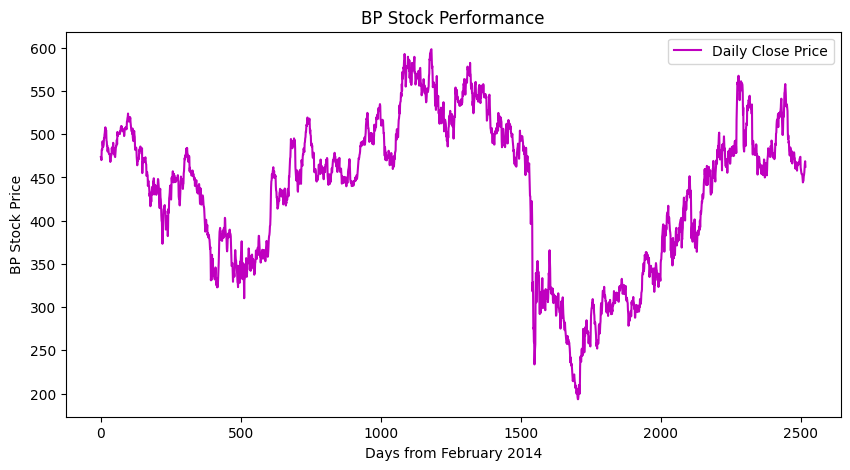

In [7]:
bp,bp_forecast = data_download('BP.L', "2014-02-01", "2024-02-01")

bp_scaler_min = MinMaxScaler()
bp_scaler_std = StandardScaler()

bp_train_std, bp_test_std, bp_ts_std, bp_train_ts_std, bp_test_ts_std=train_test_gen(
    bp, bp_scaler_std, look_back)
bp_train_min, bp_test_min, bp_ts_min, bp_train_ts_min, bp_test_ts_min=train_test_gen(
    bp, bp_scaler_min, look_back)

plt.figure(figsize=(10,5))
plt.plot(bp,label='Daily Close Price',color='m')
plt.xlabel('Days from February 2014')
plt.ylabel('BP Stock Price')
plt.title('BP Stock Performance')
plt.legend()
#plt.savefig('bp')
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


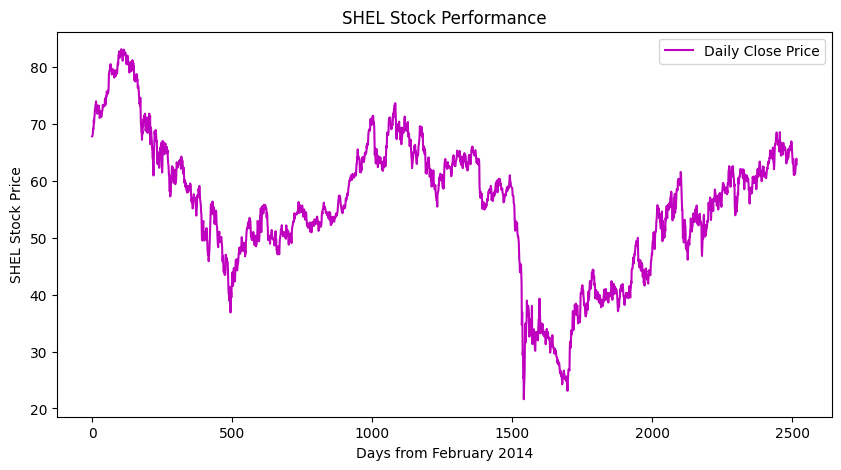

In [8]:
shel,shel_forecast = data_download('SHEL', "2014-02-01", "2024-02-01")

shel_scaler_min = MinMaxScaler()
shel_scaler_std = StandardScaler()

shel_train_std, shel_test_std, shel_ts_std, shel_train_ts_std, shel_test_ts_std=train_test_gen(shel, shel_scaler_std, look_back)
shel_train_min, shel_test_min, shel_ts_min, shel_train_ts_min, shel_test_ts_min=train_test_gen(shel, shel_scaler_min, look_back)

plt.figure(figsize=(10,5))
plt.plot(shel,label='Daily Close Price',color='m')
plt.xlabel('Days from February 2014')
plt.ylabel('SHEL Stock Price')
plt.title('SHEL Stock Performance')
plt.legend()
#plt.savefig('shel')
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


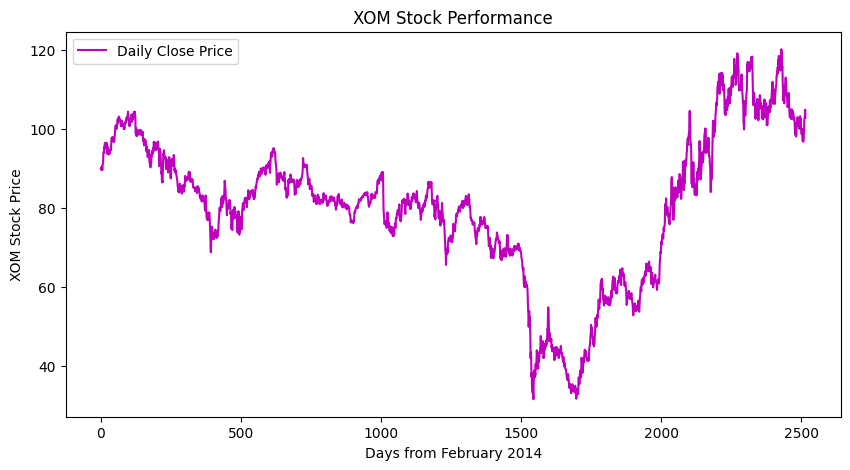

In [9]:
xom,xom_forecast = data_download('XOM', "2014-02-01", "2024-02-01")

xom_scaler_min = MinMaxScaler()
xom_scaler_std = StandardScaler()

xom_train_std, xom_test_std, xom_ts_std, xom_train_ts_std, xom_test_ts_std=train_test_gen(xom, xom_scaler_std, look_back)
xom_train_min, xom_test_min, xom_ts_min, xom_train_ts_min, xom_test_ts_min=train_test_gen(xom, xom_scaler_min, look_back)

plt.figure(figsize=(10,5))
plt.plot(xom,label='Daily Close Price',color='m')
plt.xlabel('Days from February 2014')
plt.ylabel('XOM Stock Price')
plt.title('XOM Stock Performance')
plt.legend()
#plt.savefig('xom')
plt.show()

In [10]:
cvx,cvx_forecast = data_download('CVX', "2014-02-01", "2024-02-01")

cvx_scaler_min = MinMaxScaler()
cvx_scaler_std = StandardScaler()

cvx_train_std, cvx_test_std, cvx_ts_std, cvx_train_ts_std, cvx_test_ts_std=train_test_gen(cvx, cvx_scaler_std, look_back)
cvx_train_min, cvx_test_min, cvx_ts_min, cvx_train_ts_min, cvx_test_ts_min=train_test_gen(cvx, cvx_scaler_min, look_back)

plt.figure(figsize=(10,5))
plt.plot(cvx,label='Daily Close Price',color='m')
plt.xlabel('Days from February 2014')
plt.ylabel('CVX Stock Price')
plt.title('CVX Stock Performance')
plt.legend()
#plt.savefig('cvx')
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


###Model-1 building and evaluation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 10, 25)            7600      
                                                                 
 lstm_3 (LSTM)               (None, 10)                1440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 39651 (154.89 KB)
Trainable params: 39651 (154.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


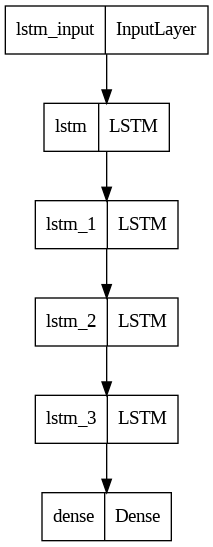

In [11]:
# Building the LSTM model - Model-1
model_1 = Sequential()
model_1.add(LSTM(units=50,activation='sigmoid', return_sequences=True,
                    input_shape=(look_back, 1)))
model_1.add(LSTM(units=50,activation='sigmoid', return_sequences=True))
model_1.add(LSTM(units=25, return_sequences=True))
model_1.add(LSTM(units=10))
model_1.add(Dense(1))

model_1.compile(optimizer='adam', loss='mean_squared_error')

model_1.summary()
plot_model(model_1)

In [12]:
model_1.fit(bp_train_ts_std, epochs=epoch,batch_size=128,verbose=2)

Epoch 1/20
63/63 - 14s - loss: 1.1770 - 14s/epoch - 216ms/step
Epoch 2/20
63/63 - 1s - loss: 1.1636 - 1s/epoch - 21ms/step
Epoch 3/20
63/63 - 1s - loss: 1.1287 - 1s/epoch - 21ms/step
Epoch 4/20
63/63 - 2s - loss: 0.8376 - 2s/epoch - 29ms/step
Epoch 5/20
63/63 - 2s - loss: 0.1641 - 2s/epoch - 30ms/step
Epoch 6/20
63/63 - 1s - loss: 0.0985 - 1s/epoch - 20ms/step
Epoch 7/20
63/63 - 1s - loss: 0.1055 - 1s/epoch - 20ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0661 - 1s/epoch - 20ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0591 - 1s/epoch - 20ms/step
Epoch 10/20
63/63 - 1s - loss: 0.0782 - 1s/epoch - 23ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0573 - 1s/epoch - 21ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0497 - 1s/epoch - 21ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0573 - 1s/epoch - 20ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0457 - 1s/epoch - 20ms/step
Epoch 15/20
63/63 - 2s - loss: 0.0483 - 2s/epoch - 28ms/step
Epoch 16/20
63/63 - 1s - loss: 0.0411 - 1s/epoch - 20ms/step
Epoch 17/20
63/63 - 1s - loss:

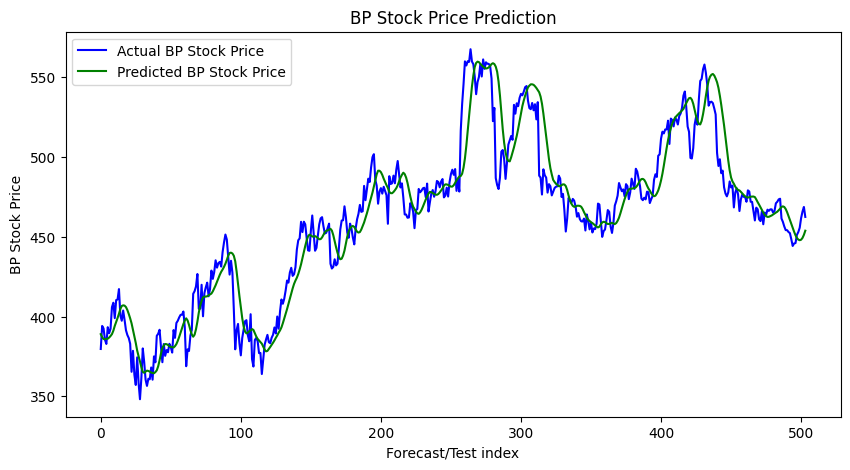

Prediction Performance Metrics on test data:
MAPE is  2.58 %
R2 Score is  0.89


In [13]:
evaluate(model_1, bp_test_std, bp_test_ts_std, bp_scaler_std, 'BP')

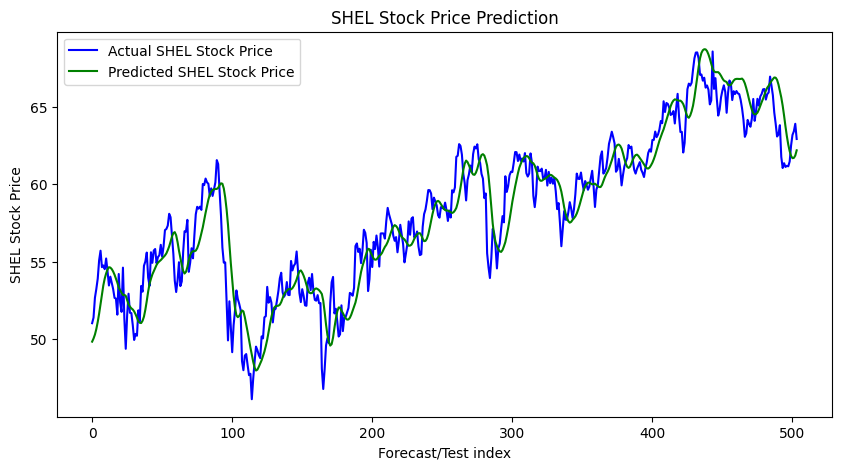

Prediction Performance Metrics on test data:
MAPE is  2.39 %
R2 Score is  0.87


In [14]:
evaluate(model_1, shel_test_std, shel_test_ts_std, shel_scaler_std, 'SHEL')

In [15]:
evaluate(model_1, xom_test_std, xom_test_ts_std, xom_scaler_std, 'XOM')

Prediction Performance Metrics on test data:
MAPE is  3.01 %
R2 Score is  0.88


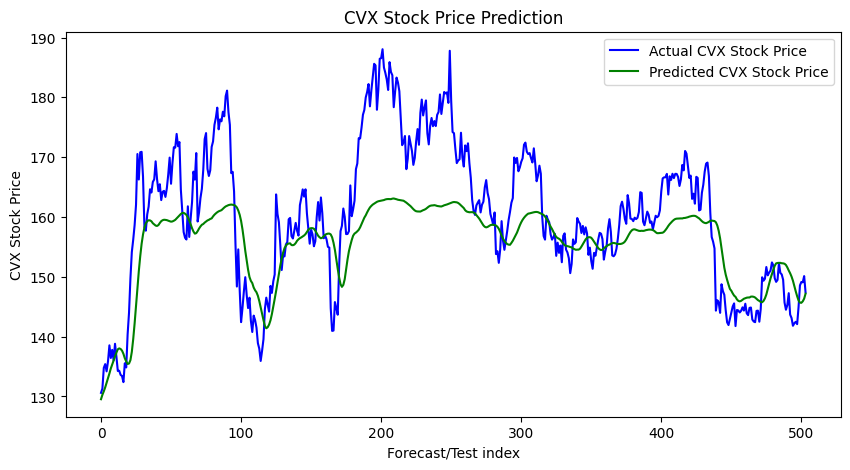

Prediction Performance Metrics on test data:
MAPE is  4.2 %
R2 Score is  0.44


In [16]:
evaluate(model_1, cvx_test_std, cvx_test_ts_std, cvx_scaler_std, 'CVX')

In [17]:
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
model_1.fit(bp_ts_std, epochs=epoch,batch_size=128,verbose=2)

Epoch 1/20
79/79 - 8s - loss: 0.0449 - 8s/epoch - 105ms/step
Epoch 2/20
79/79 - 2s - loss: 0.0358 - 2s/epoch - 21ms/step
Epoch 3/20
79/79 - 2s - loss: 0.0353 - 2s/epoch - 26ms/step
Epoch 4/20
79/79 - 2s - loss: 0.0816 - 2s/epoch - 20ms/step
Epoch 5/20
79/79 - 2s - loss: 0.0362 - 2s/epoch - 21ms/step
Epoch 6/20
79/79 - 2s - loss: 0.0295 - 2s/epoch - 22ms/step
Epoch 7/20
79/79 - 2s - loss: 0.0318 - 2s/epoch - 21ms/step
Epoch 8/20
79/79 - 2s - loss: 0.0309 - 2s/epoch - 31ms/step
Epoch 9/20
79/79 - 2s - loss: 0.0264 - 2s/epoch - 20ms/step
Epoch 10/20
79/79 - 2s - loss: 0.0288 - 2s/epoch - 25ms/step
Epoch 11/20
79/79 - 2s - loss: 0.0235 - 2s/epoch - 20ms/step
Epoch 12/20
79/79 - 2s - loss: 0.0220 - 2s/epoch - 20ms/step
Epoch 13/20
79/79 - 2s - loss: 0.0195 - 2s/epoch - 29ms/step
Epoch 14/20
79/79 - 2s - loss: 0.0254 - 2s/epoch - 31ms/step
Epoch 15/20
79/79 - 2s - loss: 0.0199 - 2s/epoch - 25ms/step
Epoch 16/20
79/79 - 2s - loss: 0.0216 - 2s/epoch - 20ms/step
Epoch 17/20
79/79 - 2s - loss: 0

In [19]:
forecast(model_1, bp_forecast, bp_test_std, bp_scaler_std, look_back, 'BP')

Forecast Performance for 1 day:
MAPE is  0.2 %
Forecast Performance for 15 day:
MAPE is  2.82 %
R2 Score is  -2.72
Forecast Performance for 30 day:
MAPE is  3.31 %
R2 Score is  -5.24


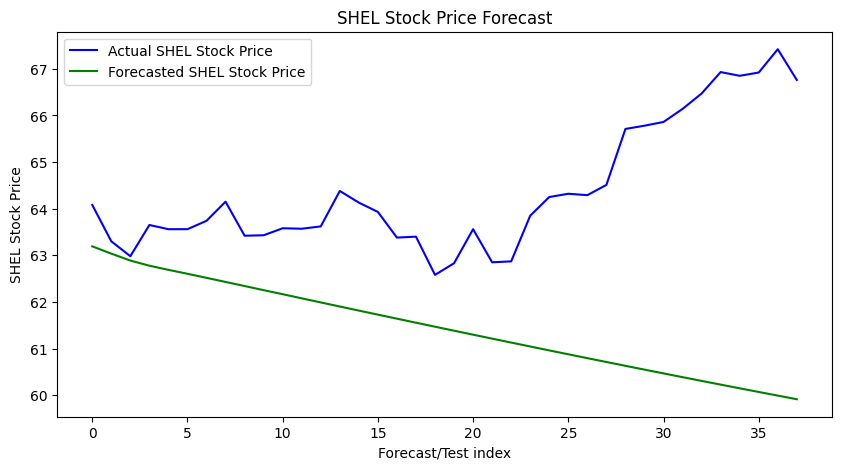

Forecast Performance for 1 day:
MAPE is  1.39 %
Forecast Performance for 15 day:
MAPE is  1.93 %
R2 Score is  -14.13
Forecast Performance for 30 day:
MAPE is  3.1 %
R2 Score is  -9.61


In [20]:
forecast(model_1, shel_forecast, shel_test_std, shel_scaler_std, look_back, 'SHEL')

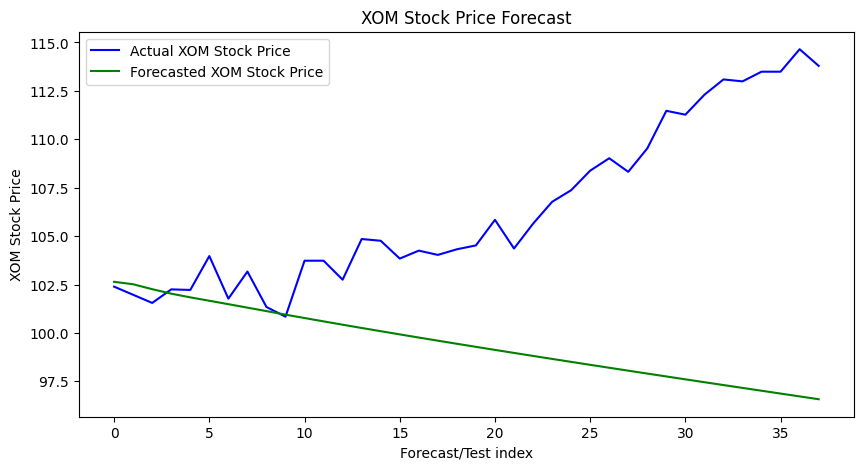

Forecast Performance for 1 day:
MAPE is  -0.24 %
Forecast Performance for 15 day:
MAPE is  1.58 %
R2 Score is  -2.6
Forecast Performance for 30 day:
MAPE is  4.37 %
R2 Score is  -4.27


In [21]:
forecast(model_1, xom_forecast, xom_test_std, xom_scaler_std, look_back, 'XOM')

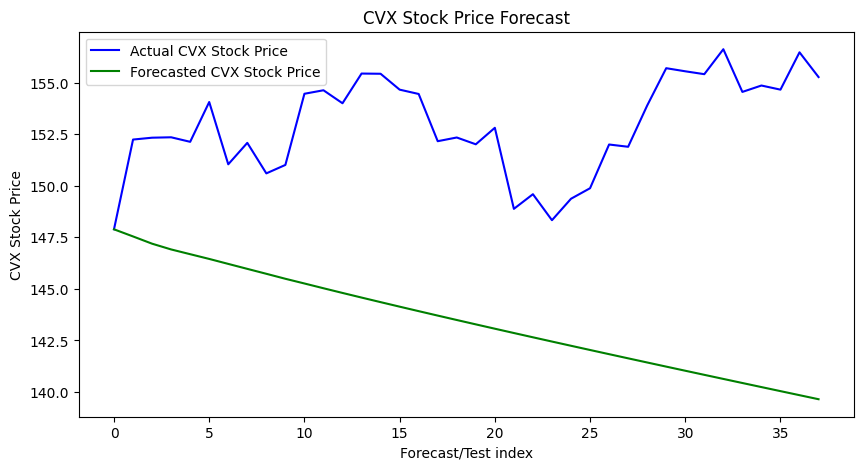

Forecast Performance for 1 day:
MAPE is  0.0 %
Forecast Performance for 15 day:
MAPE is  4.33 %
R2 Score is  -12.12
Forecast Performance for 30 day:
MAPE is  5.18 %
R2 Score is  -14.72


In [22]:
forecast(model_1, cvx_forecast, cvx_test_std, cvx_scaler_std, look_back, 'CVX')

In [23]:
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model_1.fit(bp_train_ts_min, epochs=epoch,batch_size=128,verbose=2)

Epoch 1/20
63/63 - 9s - loss: 0.0033 - 9s/epoch - 136ms/step
Epoch 2/20
63/63 - 1s - loss: 9.7953e-04 - 1s/epoch - 20ms/step
Epoch 3/20
63/63 - 1s - loss: 9.2087e-04 - 1s/epoch - 20ms/step
Epoch 4/20
63/63 - 1s - loss: 7.9407e-04 - 1s/epoch - 20ms/step
Epoch 5/20
63/63 - 1s - loss: 7.3155e-04 - 1s/epoch - 20ms/step
Epoch 6/20
63/63 - 2s - loss: 0.0014 - 2s/epoch - 28ms/step
Epoch 7/20
63/63 - 1s - loss: 6.9389e-04 - 1s/epoch - 19ms/step
Epoch 8/20
63/63 - 1s - loss: 6.2955e-04 - 1s/epoch - 21ms/step
Epoch 9/20
63/63 - 1s - loss: 7.0882e-04 - 1s/epoch - 20ms/step
Epoch 10/20
63/63 - 1s - loss: 6.1381e-04 - 1s/epoch - 20ms/step
Epoch 11/20
63/63 - 1s - loss: 7.5990e-04 - 1s/epoch - 23ms/step
Epoch 12/20
63/63 - 1s - loss: 9.0366e-04 - 1s/epoch - 23ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0042 - 1s/epoch - 20ms/step
Epoch 14/20
63/63 - 1s - loss: 7.6013e-04 - 1s/epoch - 20ms/step
Epoch 15/20
63/63 - 1s - loss: 7.4399e-04 - 1s/epoch - 20ms/step
Epoch 16/20
63/63 - 1s - loss: 5.9050e-04 - 1

In [25]:
evaluate(model_1, bp_test_min, bp_test_ts_min, bp_scaler_min, 'BP')

Prediction Performance Metrics on test data:
MAPE is  1.86 %
R2 Score is  0.95


In [26]:
evaluate(model_1, shel_test_min, shel_test_ts_min, shel_scaler_min, 'SHEL')

Prediction Performance Metrics on test data:
MAPE is  2.13 %
R2 Score is  0.9


In [27]:
evaluate(model_1, xom_test_min, xom_test_ts_min, xom_scaler_min, 'XOM')

Prediction Performance Metrics on test data:
MAPE is  1.81 %
R2 Score is  0.96


In [28]:
evaluate(model_1, cvx_test_min, cvx_test_ts_min, cvx_scaler_min, 'CVX')

Prediction Performance Metrics on test data:
MAPE is  1.75 %
R2 Score is  0.91


In [29]:
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
model_1.fit(bp_ts_min, epochs=epoch,batch_size=128,verbose=2)

Epoch 1/20
79/79 - 9s - loss: 0.0016 - 9s/epoch - 108ms/step
Epoch 2/20
79/79 - 2s - loss: 0.0013 - 2s/epoch - 22ms/step
Epoch 3/20
79/79 - 2s - loss: 6.9846e-04 - 2s/epoch - 19ms/step
Epoch 4/20
79/79 - 2s - loss: 7.7954e-04 - 2s/epoch - 20ms/step
Epoch 5/20
79/79 - 2s - loss: 0.0011 - 2s/epoch - 20ms/step
Epoch 6/20
79/79 - 2s - loss: 7.9198e-04 - 2s/epoch - 21ms/step
Epoch 7/20
79/79 - 2s - loss: 5.4313e-04 - 2s/epoch - 27ms/step
Epoch 8/20
79/79 - 2s - loss: 7.7160e-04 - 2s/epoch - 21ms/step
Epoch 9/20
79/79 - 2s - loss: 6.6523e-04 - 2s/epoch - 20ms/step
Epoch 10/20
79/79 - 2s - loss: 7.2646e-04 - 2s/epoch - 20ms/step
Epoch 11/20
79/79 - 2s - loss: 5.8932e-04 - 2s/epoch - 20ms/step
Epoch 12/20
79/79 - 2s - loss: 5.9028e-04 - 2s/epoch - 20ms/step
Epoch 13/20
79/79 - 2s - loss: 6.5608e-04 - 2s/epoch - 27ms/step
Epoch 14/20
79/79 - 2s - loss: 6.3058e-04 - 2s/epoch - 20ms/step
Epoch 15/20
79/79 - 2s - loss: 0.0012 - 2s/epoch - 20ms/step
Epoch 16/20
79/79 - 2s - loss: 5.7394e-04 - 2s/ep

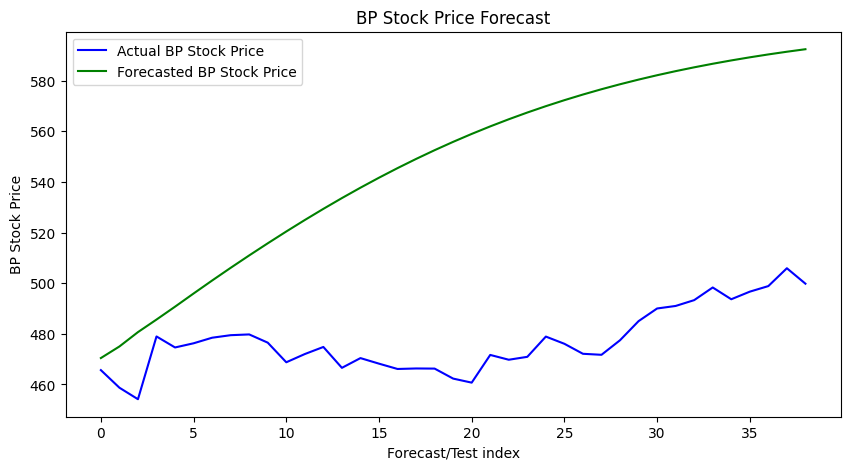

Forecast Performance for 1 day:
MAPE is  -1.02 %
Forecast Performance for 15 day:
MAPE is  7.12 %
R2 Score is  -26.41
Forecast Performance for 30 day:
MAPE is  13.37 %
R2 Score is  -105.64


In [31]:
forecast(model_1, bp_forecast, bp_test_min, bp_scaler_min, look_back, 'BP')

In [32]:
forecast(model_1, shel_forecast, shel_test_min, shel_scaler_min, look_back, 'SHEL')

Forecast Performance for 1 day:
MAPE is  -0.11 %
Forecast Performance for 15 day:
MAPE is  8.95 %
R2 Score is  -329.27
Forecast Performance for 30 day:
MAPE is  15.56 %
R2 Score is  -235.11


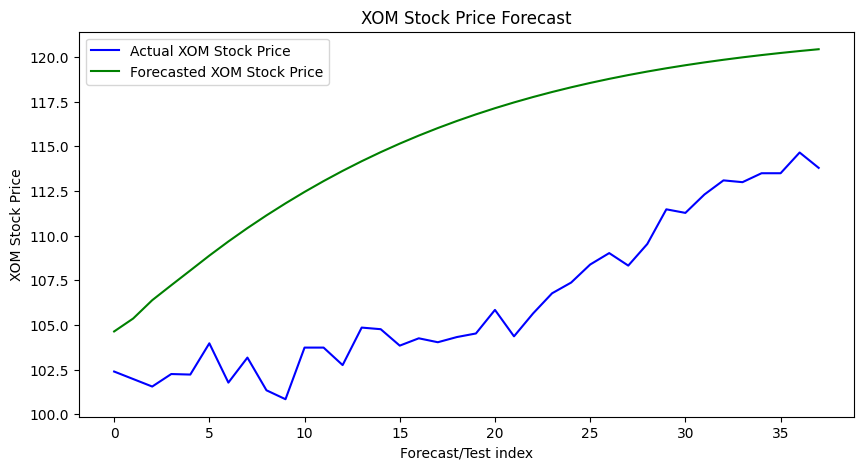

Forecast Performance for 1 day:
MAPE is  -2.19 %
Forecast Performance for 15 day:
MAPE is  7.15 %
R2 Score is  -42.09
Forecast Performance for 30 day:
MAPE is  8.78 %
R2 Score is  -12.36


In [33]:
forecast(model_1, xom_forecast, xom_test_min, xom_scaler_min, look_back, 'XOM')

In [34]:
forecast(model_1, cvx_forecast, cvx_test_min, cvx_scaler_min, look_back, 'CVX')

Forecast Performance for 1 day:
MAPE is  -1.63 %
Forecast Performance for 15 day:
MAPE is  5.64 %
R2 Score is  -24.8
Forecast Performance for 30 day:
MAPE is  11.66 %
R2 Score is  -91.93


###Model-2 Building and evaluation

In [35]:
# Building the LSTM model with dropout layer
model_2 = Sequential()
model_2.add(LSTM(units=50,activation='sigmoid', return_sequences=True,
                    input_shape=(look_back, 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units=50,activation='sigmoid', return_sequences=True))
model_2.add(Dropout(0.1))
model_2.add(LSTM(units=25, return_sequences=True))
model_2.add(Dropout(0.05))
model_2.add(LSTM(units=10))
model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='mean_squared_error')

model_2.summary()
plot_model(model_2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 25)            7600      
                                                                 
 dropout_2 (Dropout)         (None, 10, 25)            0         
                                                                 
 lstm_7 (LSTM)               (None, 10)               

In [36]:
model_2.fit(bp_train_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 9s - loss: 1.2426 - 9s/epoch - 140ms/step
Epoch 2/20
63/63 - 1s - loss: 1.1553 - 1s/epoch - 21ms/step
Epoch 3/20
63/63 - 1s - loss: 1.1590 - 1s/epoch - 21ms/step
Epoch 4/20
63/63 - 1s - loss: 1.1124 - 1s/epoch - 21ms/step
Epoch 5/20
63/63 - 2s - loss: 0.4624 - 2s/epoch - 32ms/step
Epoch 6/20
63/63 - 1s - loss: 0.1567 - 1s/epoch - 21ms/step
Epoch 7/20
63/63 - 1s - loss: 0.1188 - 1s/epoch - 23ms/step
Epoch 8/20
63/63 - 1s - loss: 0.1097 - 1s/epoch - 21ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0863 - 1s/epoch - 21ms/step
Epoch 10/20
63/63 - 2s - loss: 0.1110 - 2s/epoch - 32ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0872 - 1s/epoch - 21ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0745 - 1s/epoch - 21ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0843 - 1s/epoch - 22ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0701 - 1s/epoch - 22ms/step
Epoch 15/20
63/63 - 2s - loss: 0.0653 - 2s/epoch - 26ms/step
Epoch 16/20
63/63 - 2s - loss: 0.0661 - 2s/epoch - 31ms/step
Epoch 17/20
63/63 - 1s - loss: 0

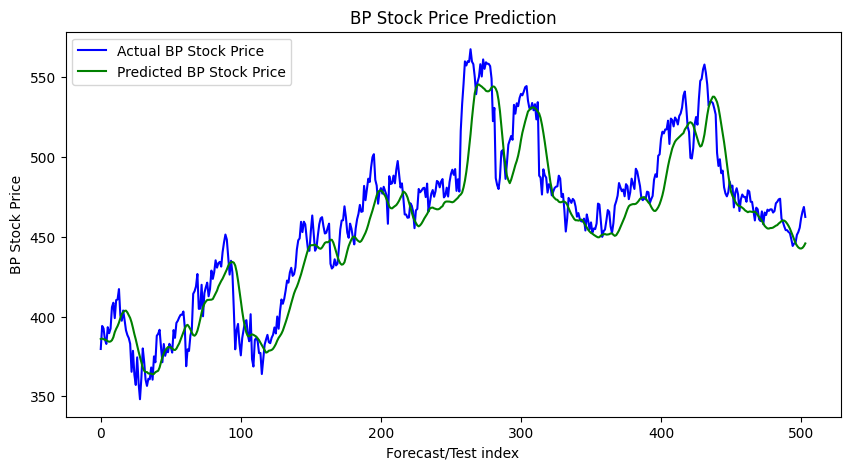

Prediction Performance Metrics on test data:
MAPE is  3.06 %
R2 Score is  0.86


In [37]:
evaluate(model_2, bp_test_std, bp_test_ts_std, bp_scaler_std, 'BP')

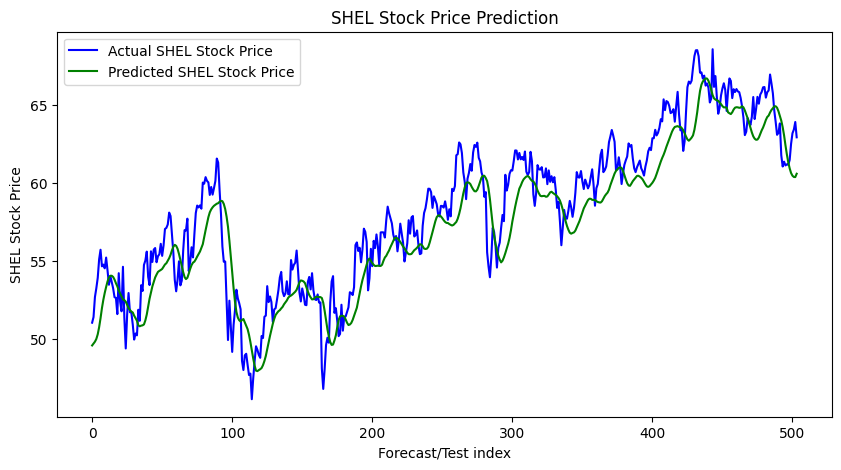

Prediction Performance Metrics on test data:
MAPE is  2.95 %
R2 Score is  0.82


In [38]:
evaluate(model_2, shel_test_std, shel_test_ts_std, shel_scaler_std, 'SHEL')

In [39]:
evaluate(model_2, xom_test_std, xom_test_ts_std, xom_scaler_std, 'XOM')

Prediction Performance Metrics on test data:
MAPE is  4.06 %
R2 Score is  0.78


In [40]:
evaluate(model_2, cvx_test_std, cvx_test_ts_std, cvx_scaler_std, 'CVX')

Prediction Performance Metrics on test data:
MAPE is  5.95 %
R2 Score is  -0.02


In [41]:
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
model_2.fit(bp_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 9s - loss: 0.0750 - 9s/epoch - 119ms/step
Epoch 2/20
79/79 - 2s - loss: 0.0609 - 2s/epoch - 20ms/step
Epoch 3/20
79/79 - 2s - loss: 0.0739 - 2s/epoch - 29ms/step
Epoch 4/20
79/79 - 2s - loss: 0.0728 - 2s/epoch - 25ms/step
Epoch 5/20
79/79 - 2s - loss: 0.0590 - 2s/epoch - 21ms/step
Epoch 6/20
79/79 - 2s - loss: 0.0501 - 2s/epoch - 21ms/step
Epoch 7/20
79/79 - 2s - loss: 0.0541 - 2s/epoch - 21ms/step
Epoch 8/20
79/79 - 2s - loss: 0.0494 - 2s/epoch - 28ms/step
Epoch 9/20
79/79 - 2s - loss: 0.0484 - 2s/epoch - 25ms/step
Epoch 10/20
79/79 - 2s - loss: 0.0525 - 2s/epoch - 20ms/step
Epoch 11/20
79/79 - 2s - loss: 0.0414 - 2s/epoch - 20ms/step
Epoch 12/20
79/79 - 2s - loss: 0.0485 - 2s/epoch - 21ms/step
Epoch 13/20
79/79 - 2s - loss: 0.0410 - 2s/epoch - 20ms/step
Epoch 14/20
79/79 - 2s - loss: 0.0411 - 2s/epoch - 31ms/step
Epoch 15/20
79/79 - 2s - loss: 0.0406 - 2s/epoch - 21ms/step
Epoch 16/20
79/79 - 2s - loss: 0.0414 - 2s/epoch - 20ms/step
Epoch 17/20
79/79 - 2s - loss: 0

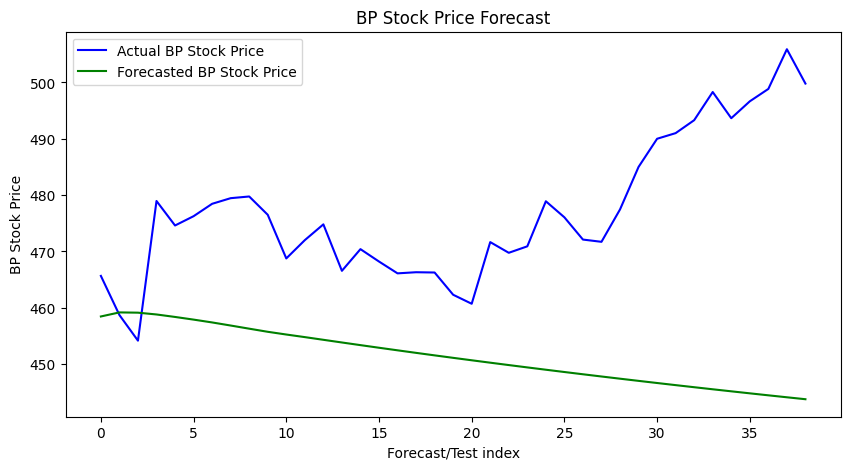

Forecast Performance for 1 day:
MAPE is  1.55 %
Forecast Performance for 15 day:
MAPE is  3.32 %
R2 Score is  -4.24
Forecast Performance for 30 day:
MAPE is  3.88 %
R2 Score is  -7.34


In [43]:
forecast(model_2, bp_forecast, bp_test_std, bp_scaler_std, look_back, 'BP')

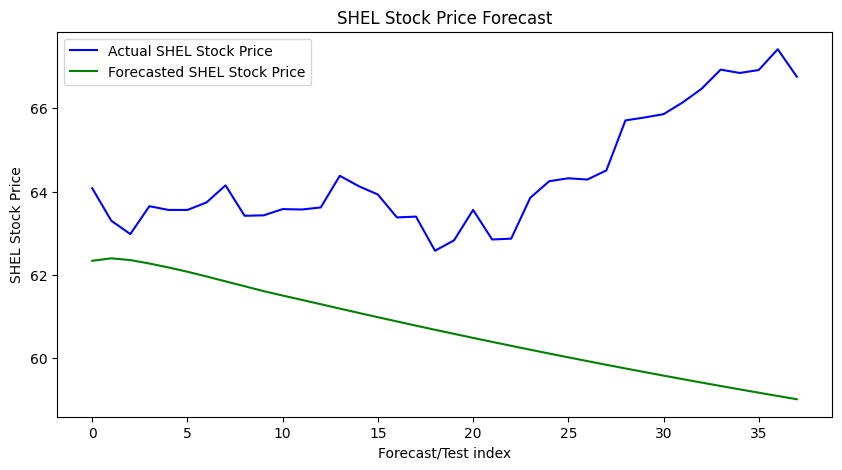

Forecast Performance for 1 day:
MAPE is  2.72 %
Forecast Performance for 15 day:
MAPE is  2.92 %
R2 Score is  -29.98
Forecast Performance for 30 day:
MAPE is  4.24 %
R2 Score is  -16.67


In [44]:
forecast(model_2, shel_forecast, shel_test_std, shel_scaler_std, look_back, 'SHEL')

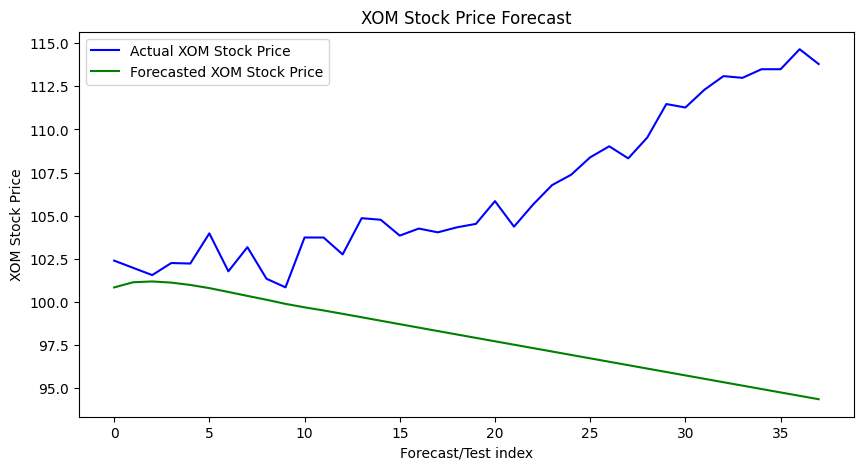

Forecast Performance for 1 day:
MAPE is  1.52 %
Forecast Performance for 15 day:
MAPE is  2.44 %
R2 Score is  -5.63
Forecast Performance for 30 day:
MAPE is  5.51 %
R2 Score is  -6.49


In [45]:
forecast(model_2, xom_forecast, xom_test_std, xom_scaler_std, look_back, 'XOM')

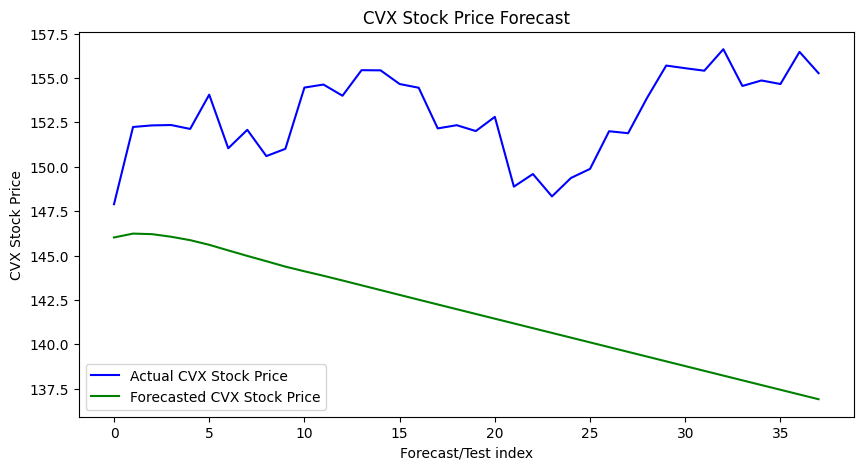

Forecast Performance for 1 day:
MAPE is  1.27 %
Forecast Performance for 15 day:
MAPE is  5.06 %
R2 Score is  -16.13
Forecast Performance for 30 day:
MAPE is  6.13 %
R2 Score is  -20.45


In [46]:
forecast(model_2, cvx_forecast, cvx_test_std, cvx_scaler_std, look_back, 'CVX')

In [47]:
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
model_2.fit(bp_train_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 9s - loss: 0.0084 - 9s/epoch - 141ms/step
Epoch 2/20
63/63 - 2s - loss: 0.0058 - 2s/epoch - 25ms/step
Epoch 3/20
63/63 - 1s - loss: 0.0061 - 1s/epoch - 21ms/step
Epoch 4/20
63/63 - 1s - loss: 0.0043 - 1s/epoch - 23ms/step
Epoch 5/20
63/63 - 1s - loss: 0.0042 - 1s/epoch - 22ms/step
Epoch 6/20
63/63 - 1s - loss: 0.0045 - 1s/epoch - 21ms/step
Epoch 7/20
63/63 - 2s - loss: 0.0038 - 2s/epoch - 30ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0044 - 1s/epoch - 21ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0040 - 1s/epoch - 21ms/step
Epoch 10/20
63/63 - 1s - loss: 0.0036 - 1s/epoch - 21ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0033 - 1s/epoch - 21ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0030 - 1s/epoch - 21ms/step
Epoch 13/20
63/63 - 2s - loss: 0.0041 - 2s/epoch - 25ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0035 - 1s/epoch - 23ms/step
Epoch 15/20
63/63 - 1s - loss: 0.0031 - 1s/epoch - 22ms/step
Epoch 16/20
63/63 - 1s - loss: 0.0031 - 1s/epoch - 22ms/step
Epoch 17/20
63/63 - 1s - loss: 0

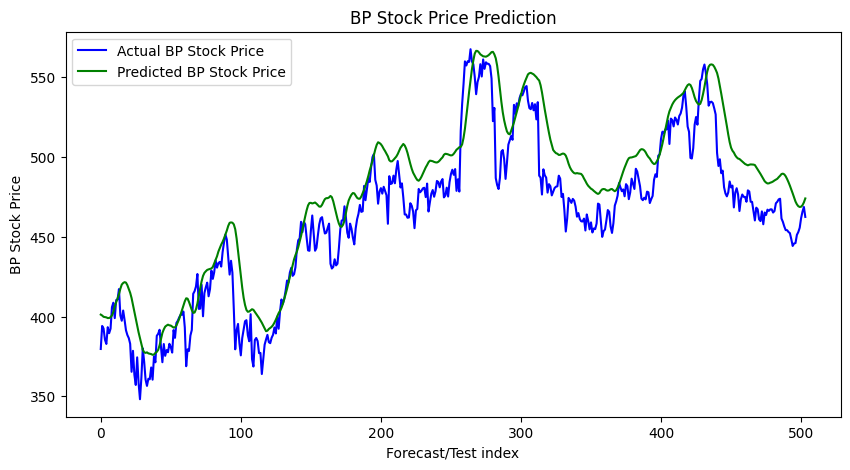

Prediction Performance Metrics on test data:
MAPE is  4.15 %
R2 Score is  0.78


In [49]:
evaluate(model_2, bp_test_min, bp_test_ts_min, bp_scaler_min, 'BP')

In [50]:
evaluate(model_2, shel_test_min, shel_test_ts_min, shel_scaler_min, 'SHEL')

Prediction Performance Metrics on test data:
MAPE is  4.64 %
R2 Score is  0.59


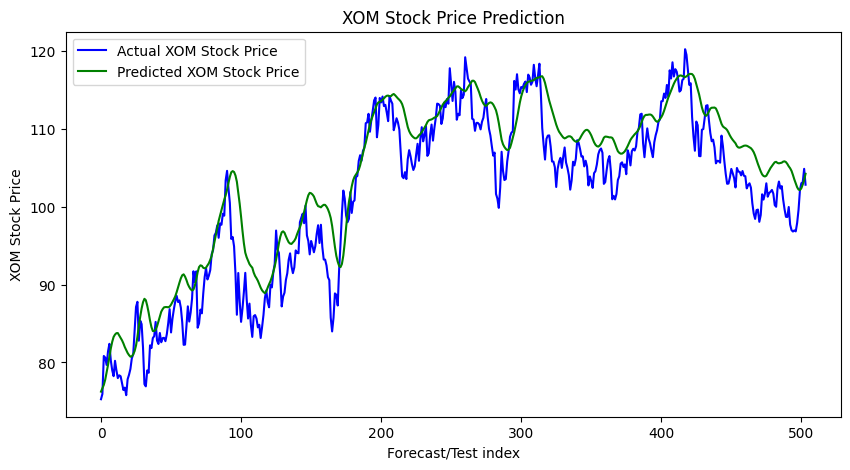

Prediction Performance Metrics on test data:
MAPE is  3.64 %
R2 Score is  0.83


In [51]:
evaluate(model_2, xom_test_min, xom_test_ts_min, xom_scaler_min, 'XOM')

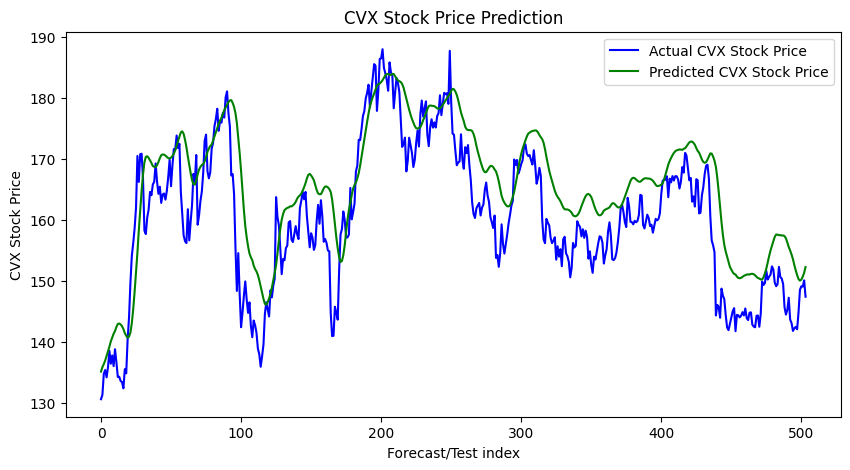

Prediction Performance Metrics on test data:
MAPE is  3.99 %
R2 Score is  0.6


In [52]:
evaluate(model_2, cvx_test_min, cvx_test_ts_min, cvx_scaler_min, 'CVX')

In [53]:
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
model_2.fit(bp_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 9s - loss: 0.0032 - 9s/epoch - 113ms/step
Epoch 2/20
79/79 - 2s - loss: 0.0030 - 2s/epoch - 23ms/step
Epoch 3/20
79/79 - 2s - loss: 0.0026 - 2s/epoch - 21ms/step
Epoch 4/20
79/79 - 2s - loss: 0.0027 - 2s/epoch - 21ms/step
Epoch 5/20
79/79 - 2s - loss: 0.0033 - 2s/epoch - 32ms/step
Epoch 6/20
79/79 - 2s - loss: 0.0029 - 2s/epoch - 22ms/step
Epoch 7/20
79/79 - 2s - loss: 0.0025 - 2s/epoch - 21ms/step
Epoch 8/20
79/79 - 2s - loss: 0.0026 - 2s/epoch - 21ms/step
Epoch 9/20
79/79 - 2s - loss: 0.0027 - 2s/epoch - 23ms/step
Epoch 10/20
79/79 - 2s - loss: 0.0038 - 2s/epoch - 25ms/step
Epoch 11/20
79/79 - 2s - loss: 0.0030 - 2s/epoch - 25ms/step
Epoch 12/20
79/79 - 2s - loss: 0.0027 - 2s/epoch - 21ms/step
Epoch 13/20
79/79 - 2s - loss: 0.0027 - 2s/epoch - 21ms/step
Epoch 14/20
79/79 - 2s - loss: 0.0035 - 2s/epoch - 21ms/step
Epoch 15/20
79/79 - 2s - loss: 0.0028 - 2s/epoch - 21ms/step
Epoch 16/20
79/79 - 3s - loss: 0.0025 - 3s/epoch - 33ms/step
Epoch 17/20
79/79 - 2s - loss: 0

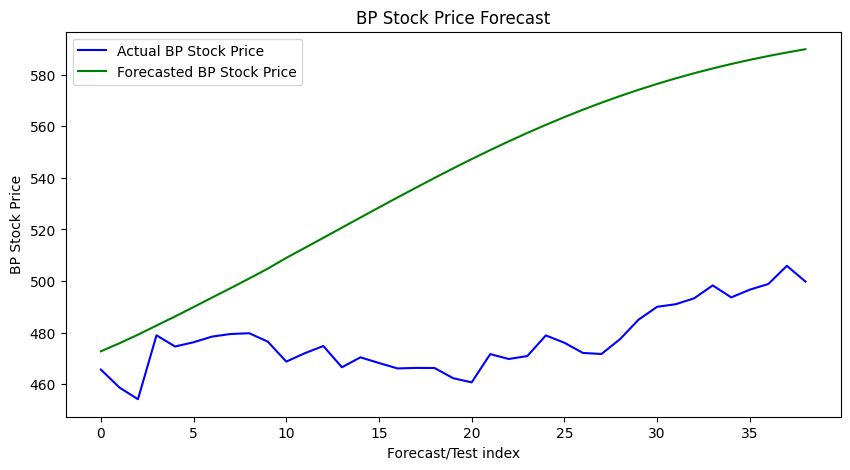

Forecast Performance for 1 day:
MAPE is  -1.52 %
Forecast Performance for 15 day:
MAPE is  5.56 %
R2 Score is  -15.8
Forecast Performance for 30 day:
MAPE is  11.5 %
R2 Score is  -80.98


In [55]:
forecast(model_2, bp_forecast, bp_test_min, bp_scaler_min, look_back, 'BP')

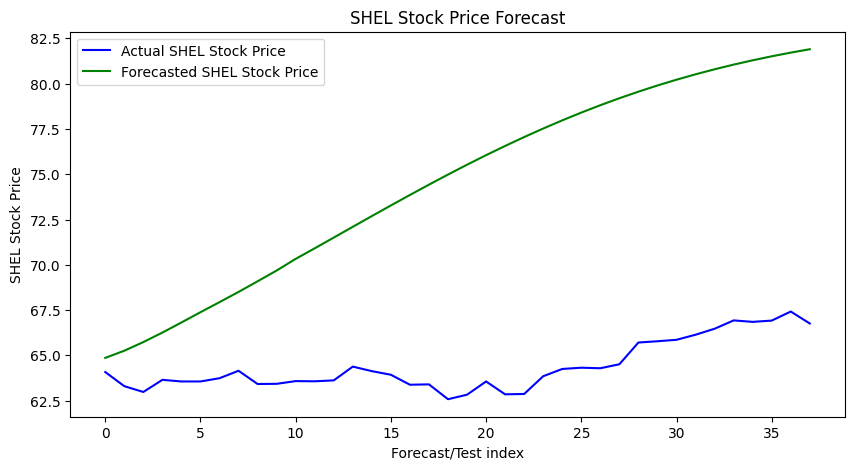

Forecast Performance for 1 day:
MAPE is  -1.22 %
Forecast Performance for 15 day:
MAPE is  7.73 %
R2 Score is  -234.23
Forecast Performance for 30 day:
MAPE is  14.04 %
R2 Score is  -193.53


In [56]:
forecast(model_2, shel_forecast, shel_test_min, shel_scaler_min, look_back, 'SHEL')

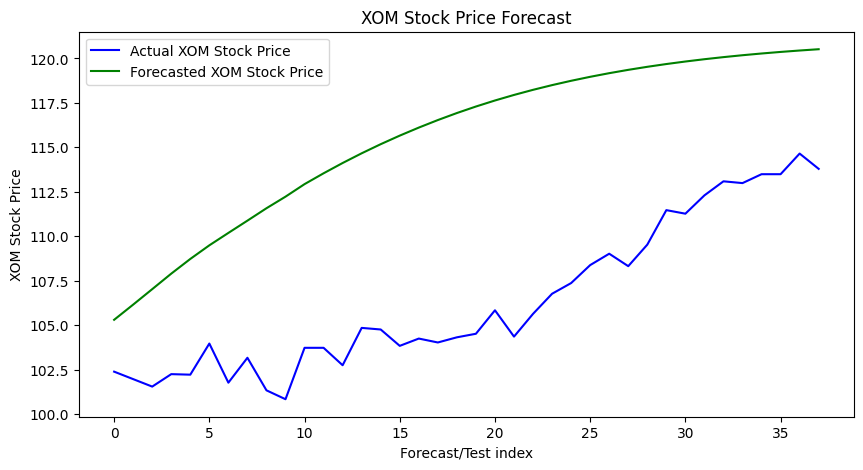

Forecast Performance for 1 day:
MAPE is  -2.85 %
Forecast Performance for 15 day:
MAPE is  7.69 %
R2 Score is  -47.76
Forecast Performance for 30 day:
MAPE is  9.26 %
R2 Score is  -13.69


In [57]:
forecast(model_2, xom_forecast, xom_test_min, xom_scaler_min, look_back, 'XOM')

In [58]:
forecast(model_2, cvx_forecast, cvx_test_min, cvx_scaler_min, look_back, 'CVX')

Forecast Performance for 1 day:
MAPE is  -2.98 %
Forecast Performance for 15 day:
MAPE is  5.38 %
R2 Score is  -20.72
Forecast Performance for 30 day:
MAPE is  11.24 %
R2 Score is  -85.45


###Model-3 building and evaluation

In [59]:
#Model 3 with GRU layers
model_3 = tf.keras.models.Sequential()
model_3.add(tf.keras.layers.GRU(units=50,activation='sigmoid', return_sequences=True,
                    input_shape=(look_back, 1)))
model_3.add(tf.keras.layers.GRU(units=25,activation='sigmoid'))
model_3.add(tf.keras.layers.Dense(1))

model_3.compile(optimizer='adam', loss='mean_squared_error')
model_3.summary()
plot_model(model_3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 25)                5775      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13751 (53.71 KB)
Trainable params: 13751 (53.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
model_3.fit(bp_train_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 4s - loss: 1.2711 - 4s/epoch - 58ms/step
Epoch 2/20
63/63 - 1s - loss: 1.1254 - 748ms/epoch - 12ms/step
Epoch 3/20
63/63 - 1s - loss: 0.9824 - 722ms/epoch - 11ms/step
Epoch 4/20
63/63 - 1s - loss: 0.8424 - 716ms/epoch - 11ms/step
Epoch 5/20
63/63 - 1s - loss: 0.4470 - 714ms/epoch - 11ms/step
Epoch 6/20
63/63 - 1s - loss: 0.1513 - 707ms/epoch - 11ms/step
Epoch 7/20
63/63 - 1s - loss: 0.0767 - 824ms/epoch - 13ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0708 - 1s/epoch - 20ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0702 - 1s/epoch - 16ms/step
Epoch 10/20
63/63 - 1s - loss: 0.0647 - 712ms/epoch - 11ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0627 - 722ms/epoch - 11ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0609 - 734ms/epoch - 12ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0602 - 769ms/epoch - 12ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0643 - 775ms/epoch - 12ms/step
Epoch 15/20
63/63 - 1s - loss: 0.0560 - 728ms/epoch - 12ms/step
Epoch 16/20
63/63 - 1s - loss: 0.0577 - 735ms/epoch - 12ms

In [61]:
evaluate(model_3, bp_test_std, bp_test_ts_std, bp_scaler_std, 'BP')

Prediction Performance Metrics on test data:
MAPE is  3.04 %
R2 Score is  0.87


In [62]:
evaluate(model_3, shel_test_std, shel_test_ts_std, shel_scaler_std, 'SHEL')

Prediction Performance Metrics on test data:
MAPE is  2.71 %
R2 Score is  0.83


In [63]:
evaluate(model_3, xom_test_std, xom_test_ts_std, xom_scaler_std, 'XOM')

Prediction Performance Metrics on test data:
MAPE is  3.52 %
R2 Score is  0.83


In [64]:
evaluate(model_3, cvx_test_std, cvx_test_ts_std, cvx_scaler_std, 'CVX')

Prediction Performance Metrics on test data:
MAPE is  4.92 %
R2 Score is  0.29


In [65]:
model_3.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
model_3.fit(bp_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 5s - loss: 0.0480 - 5s/epoch - 58ms/step
Epoch 2/20
79/79 - 1s - loss: 0.0446 - 930ms/epoch - 12ms/step
Epoch 3/20
79/79 - 1s - loss: 0.0401 - 903ms/epoch - 11ms/step
Epoch 4/20
79/79 - 1s - loss: 0.0390 - 883ms/epoch - 11ms/step
Epoch 5/20
79/79 - 1s - loss: 0.0339 - 896ms/epoch - 11ms/step
Epoch 6/20
79/79 - 1s - loss: 0.0339 - 891ms/epoch - 11ms/step
Epoch 7/20
79/79 - 1s - loss: 0.0308 - 920ms/epoch - 12ms/step
Epoch 8/20
79/79 - 1s - loss: 0.0313 - 895ms/epoch - 11ms/step
Epoch 9/20
79/79 - 1s - loss: 0.0298 - 1s/epoch - 17ms/step
Epoch 10/20
79/79 - 1s - loss: 0.0290 - 1s/epoch - 18ms/step
Epoch 11/20
79/79 - 1s - loss: 0.0248 - 1s/epoch - 13ms/step
Epoch 12/20
79/79 - 1s - loss: 0.0227 - 962ms/epoch - 12ms/step
Epoch 13/20
79/79 - 1s - loss: 0.0211 - 918ms/epoch - 12ms/step
Epoch 14/20
79/79 - 1s - loss: 0.0237 - 893ms/epoch - 11ms/step
Epoch 15/20
79/79 - 1s - loss: 0.0196 - 937ms/epoch - 12ms/step
Epoch 16/20
79/79 - 1s - loss: 0.0200 - 899ms/epoch - 11ms/st

In [67]:
forecast(model_3, bp_forecast, bp_test_std, bp_scaler_std, look_back, 'BP')

Forecast Performance for 1 day:
MAPE is  -0.67 %
Forecast Performance for 15 day:
MAPE is  3.35 %
R2 Score is  -5.38
Forecast Performance for 30 day:
MAPE is  6.35 %
R2 Score is  -23.26


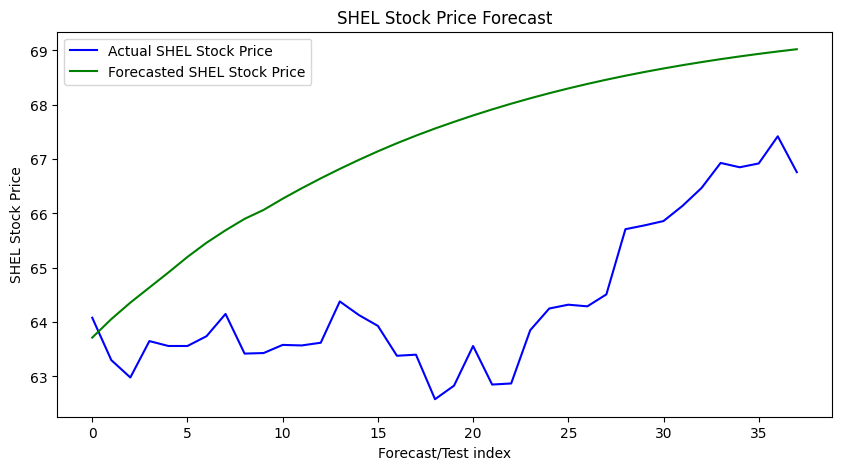

Forecast Performance for 1 day:
MAPE is  0.57 %
Forecast Performance for 15 day:
MAPE is  3.01 %
R2 Score is  -33.48
Forecast Performance for 30 day:
MAPE is  4.72 %
R2 Score is  -19.9


In [68]:
forecast(model_3, shel_forecast, shel_test_std, shel_scaler_std, look_back, 'SHEL')

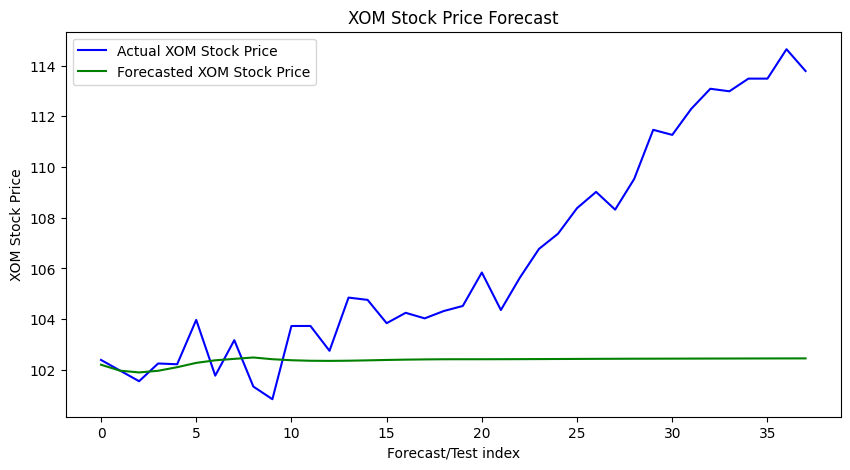

Forecast Performance for 1 day:
MAPE is  0.18 %
Forecast Performance for 15 day:
MAPE is  0.95 %
R2 Score is  -0.11
Forecast Performance for 30 day:
MAPE is  2.37 %
R2 Score is  -0.7


In [69]:
forecast(model_3, xom_forecast, xom_test_std, xom_scaler_std, look_back, 'XOM')

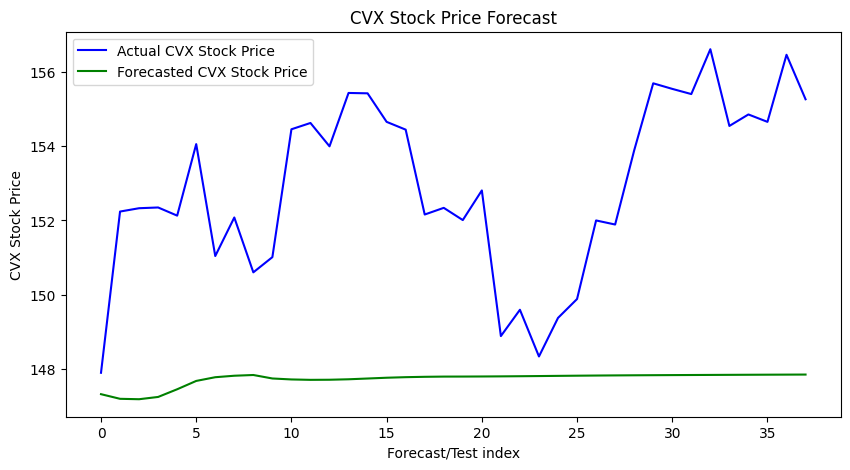

Forecast Performance for 1 day:
MAPE is  0.39 %
Forecast Performance for 15 day:
MAPE is  3.3 %
R2 Score is  -6.39
Forecast Performance for 30 day:
MAPE is  2.98 %
R2 Score is  -4.61


In [70]:
forecast(model_3, cvx_forecast, cvx_test_std, cvx_scaler_std, look_back, 'CVX')

In [71]:
model_3.compile(optimizer='adam', loss='mean_squared_error')

In [72]:
model_3.fit(bp_train_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 4s - loss: 9.2257e-04 - 4s/epoch - 56ms/step
Epoch 2/20
63/63 - 1s - loss: 6.7179e-04 - 868ms/epoch - 14ms/step
Epoch 3/20
63/63 - 1s - loss: 6.7426e-04 - 1s/epoch - 18ms/step
Epoch 4/20
63/63 - 1s - loss: 0.0011 - 1s/epoch - 17ms/step
Epoch 5/20
63/63 - 1s - loss: 5.8206e-04 - 711ms/epoch - 11ms/step
Epoch 6/20
63/63 - 1s - loss: 7.9053e-04 - 714ms/epoch - 11ms/step
Epoch 7/20
63/63 - 1s - loss: 6.7413e-04 - 681ms/epoch - 11ms/step
Epoch 8/20
63/63 - 1s - loss: 6.5041e-04 - 719ms/epoch - 11ms/step
Epoch 9/20
63/63 - 1s - loss: 6.3184e-04 - 730ms/epoch - 12ms/step
Epoch 10/20
63/63 - 1s - loss: 5.5263e-04 - 822ms/epoch - 13ms/step
Epoch 11/20
63/63 - 1s - loss: 6.2575e-04 - 747ms/epoch - 12ms/step
Epoch 12/20
63/63 - 1s - loss: 9.0794e-04 - 724ms/epoch - 11ms/step
Epoch 13/20
63/63 - 1s - loss: 8.4807e-04 - 739ms/epoch - 12ms/step
Epoch 14/20
63/63 - 1s - loss: 7.1691e-04 - 1s/epoch - 18ms/step
Epoch 15/20
63/63 - 1s - loss: 7.1942e-04 - 1s/epoch - 18ms/step
Epoch 16

In [73]:
evaluate(model_3, bp_test_min, bp_test_ts_min, bp_scaler_min, 'BP')

Prediction Performance Metrics on test data:
MAPE is  1.53 %
R2 Score is  0.97


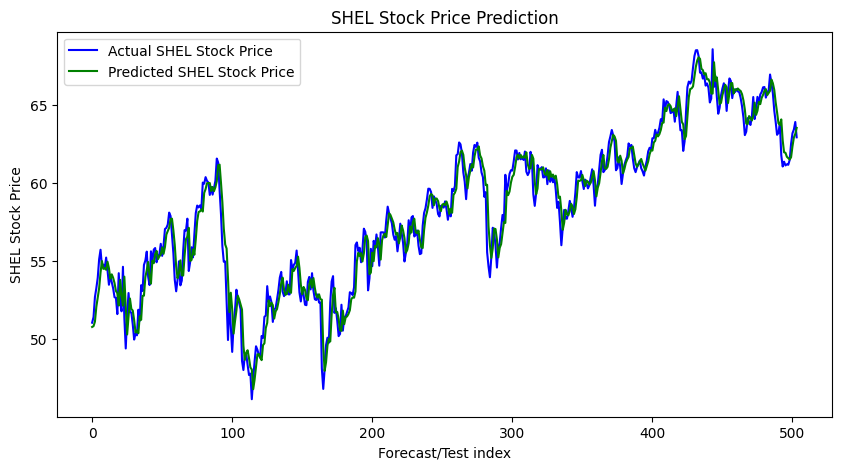

Prediction Performance Metrics on test data:
MAPE is  1.4 %
R2 Score is  0.95


In [74]:
evaluate(model_3, shel_test_min, shel_test_ts_min, shel_scaler_min, 'SHEL')

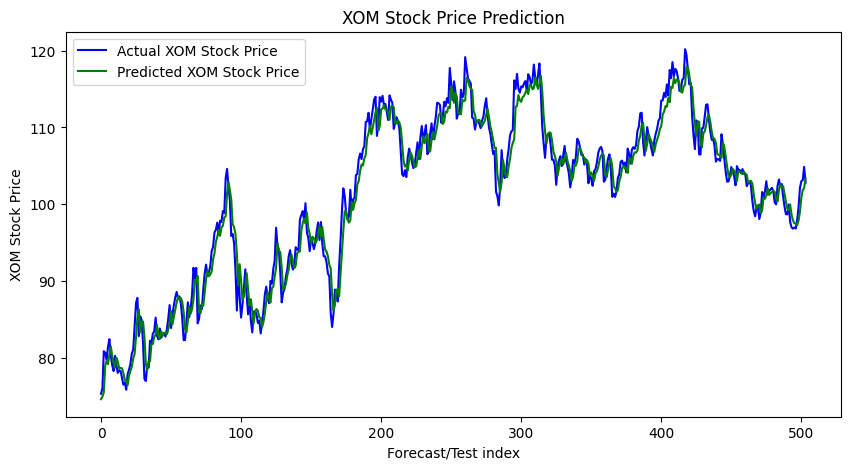

Prediction Performance Metrics on test data:
MAPE is  1.6 %
R2 Score is  0.97


In [75]:
evaluate(model_3, xom_test_min, xom_test_ts_min, xom_scaler_min, 'XOM')

In [76]:
evaluate(model_3, cvx_test_min, cvx_test_ts_min, cvx_scaler_min, 'CVX')

Prediction Performance Metrics on test data:
MAPE is  1.51 %
R2 Score is  0.93


In [77]:
model_3.compile(optimizer='adam', loss='mean_squared_error')

In [78]:
model_3.fit(bp_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 4s - loss: 9.7107e-04 - 4s/epoch - 51ms/step
Epoch 2/20
79/79 - 1s - loss: 5.9330e-04 - 1s/epoch - 14ms/step
Epoch 3/20
79/79 - 1s - loss: 6.2026e-04 - 1s/epoch - 18ms/step
Epoch 4/20
79/79 - 1s - loss: 6.8473e-04 - 932ms/epoch - 12ms/step
Epoch 5/20
79/79 - 1s - loss: 5.3622e-04 - 1s/epoch - 13ms/step
Epoch 6/20
79/79 - 1s - loss: 4.8558e-04 - 960ms/epoch - 12ms/step
Epoch 7/20
79/79 - 1s - loss: 5.9548e-04 - 908ms/epoch - 11ms/step
Epoch 8/20
79/79 - 1s - loss: 8.5966e-04 - 945ms/epoch - 12ms/step
Epoch 9/20
79/79 - 1s - loss: 6.8067e-04 - 947ms/epoch - 12ms/step
Epoch 10/20
79/79 - 1s - loss: 6.1596e-04 - 956ms/epoch - 12ms/step
Epoch 11/20
79/79 - 1s - loss: 6.1799e-04 - 898ms/epoch - 11ms/step
Epoch 12/20
79/79 - 2s - loss: 7.5650e-04 - 2s/epoch - 20ms/step
Epoch 13/20
79/79 - 1s - loss: 5.3481e-04 - 1s/epoch - 16ms/step
Epoch 14/20
79/79 - 1s - loss: 5.1332e-04 - 990ms/epoch - 13ms/step
Epoch 15/20
79/79 - 1s - loss: 4.7186e-04 - 914ms/epoch - 12ms/step
Epoch 1

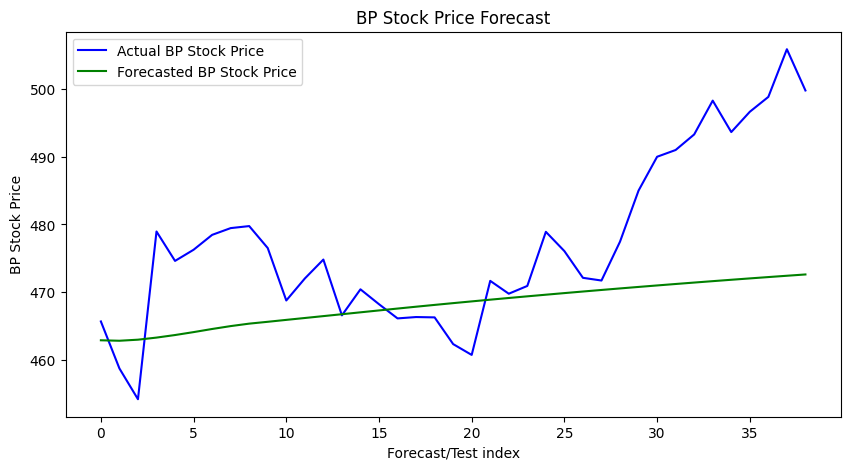

Forecast Performance for 1 day:
MAPE is  0.6 %
Forecast Performance for 15 day:
MAPE is  1.81 %
R2 Score is  -0.76
Forecast Performance for 30 day:
MAPE is  1.36 %
R2 Score is  -0.38


In [79]:
forecast(model_3, bp_forecast, bp_test_min, bp_scaler_min, look_back, 'BP')

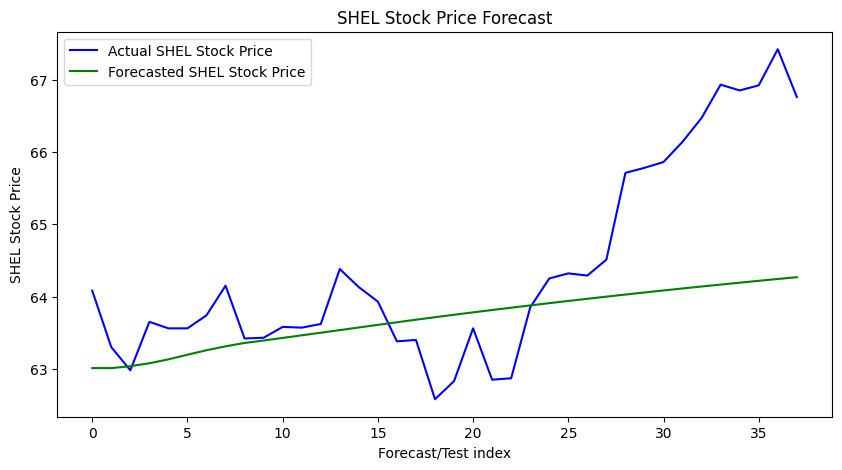

Forecast Performance for 1 day:
MAPE is  1.67 %
Forecast Performance for 15 day:
MAPE is  0.62 %
R2 Score is  -1.05
Forecast Performance for 30 day:
MAPE is  0.84 %
R2 Score is  0.06


In [80]:
forecast(model_3, shel_forecast, shel_test_min, shel_scaler_min, look_back, 'SHEL')

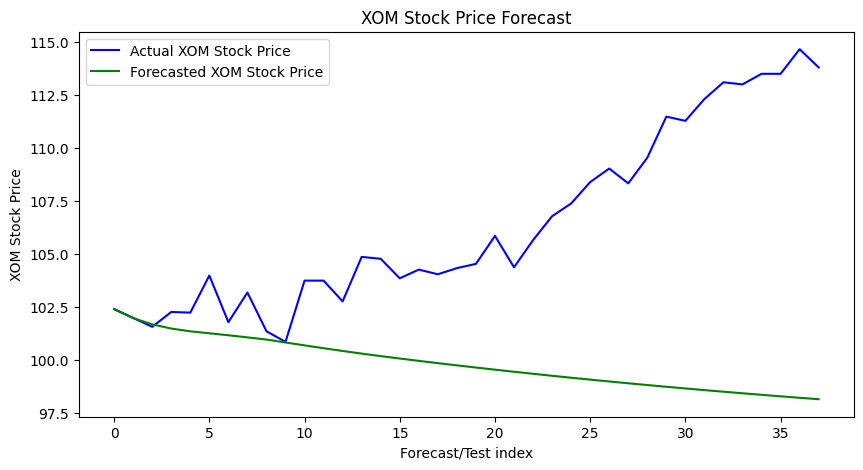

Forecast Performance for 1 day:
MAPE is  0.01 %
Forecast Performance for 15 day:
MAPE is  1.63 %
R2 Score is  -2.78
Forecast Performance for 30 day:
MAPE is  4.15 %
R2 Score is  -3.61


In [81]:
forecast(model_3, xom_forecast, xom_test_min, xom_scaler_min, look_back, 'XOM')

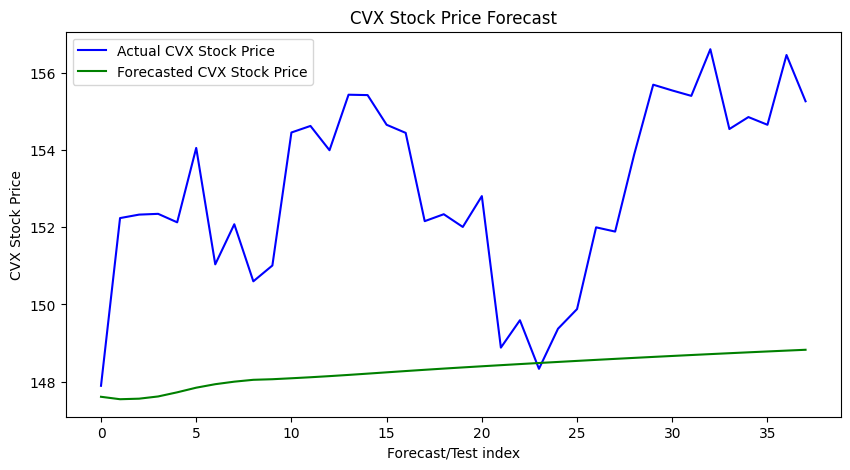

Forecast Performance for 1 day:
MAPE is  0.19 %
Forecast Performance for 15 day:
MAPE is  3.09 %
R2 Score is  -5.53
Forecast Performance for 30 day:
MAPE is  2.67 %
R2 Score is  -3.7


In [82]:
forecast(model_3, cvx_forecast, cvx_test_min, cvx_scaler_min, look_back, 'CVX')

###Model-4 Building and evaluation

In [83]:
#Model 4 with GRU and Dropout layers
model_4 = tf.keras.models.Sequential()
model_4.add(tf.keras.layers.GRU(units=50,activation='sigmoid', return_sequences=True,
                    input_shape=(look_back, 1)))
model_4.add(tf.keras.layers.Dropout(0.2))
model_4.add(tf.keras.layers.GRU(units=25,activation='sigmoid'))
model_4.add(tf.keras.layers.Dropout(0.2))
model_4.add(tf.keras.layers.Dense(1))
model_4.compile(optimizer='adam', loss='mean_squared_error')
model_4.summary()
plot_model(model_4)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 10, 50)            7950      
                                                                 
 dropout_3 (Dropout)         (None, 10, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 25)                5775      
                                                                 
 dropout_4 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13751 (53.71 KB)
Trainable params: 13751 (53.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
model_4.fit(bp_train_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 4s - loss: 1.3950 - 4s/epoch - 61ms/step
Epoch 2/20
63/63 - 1s - loss: 1.2252 - 831ms/epoch - 13ms/step
Epoch 3/20
63/63 - 1s - loss: 1.0978 - 737ms/epoch - 12ms/step
Epoch 4/20
63/63 - 1s - loss: 0.8610 - 729ms/epoch - 12ms/step
Epoch 5/20
63/63 - 1s - loss: 0.5583 - 809ms/epoch - 13ms/step
Epoch 6/20
63/63 - 1s - loss: 0.2440 - 1s/epoch - 19ms/step
Epoch 7/20
63/63 - 1s - loss: 0.1822 - 915ms/epoch - 15ms/step
Epoch 8/20
63/63 - 1s - loss: 0.1648 - 732ms/epoch - 12ms/step
Epoch 9/20
63/63 - 1s - loss: 0.1476 - 758ms/epoch - 12ms/step
Epoch 10/20
63/63 - 1s - loss: 0.1451 - 713ms/epoch - 11ms/step
Epoch 11/20
63/63 - 1s - loss: 0.1432 - 725ms/epoch - 12ms/step
Epoch 12/20
63/63 - 1s - loss: 0.1343 - 749ms/epoch - 12ms/step
Epoch 13/20
63/63 - 1s - loss: 0.1313 - 715ms/epoch - 11ms/step
Epoch 14/20
63/63 - 1s - loss: 0.1224 - 841ms/epoch - 13ms/step
Epoch 15/20
63/63 - 1s - loss: 0.1265 - 772ms/epoch - 12ms/step
Epoch 16/20
63/63 - 1s - loss: 0.1176 - 1s/epoch - 16ms

In [85]:
evaluate(model_4, bp_test_std, bp_test_ts_std, bp_scaler_std, 'BP')

Prediction Performance Metrics on test data:
MAPE is  3.54 %
R2 Score is  0.83


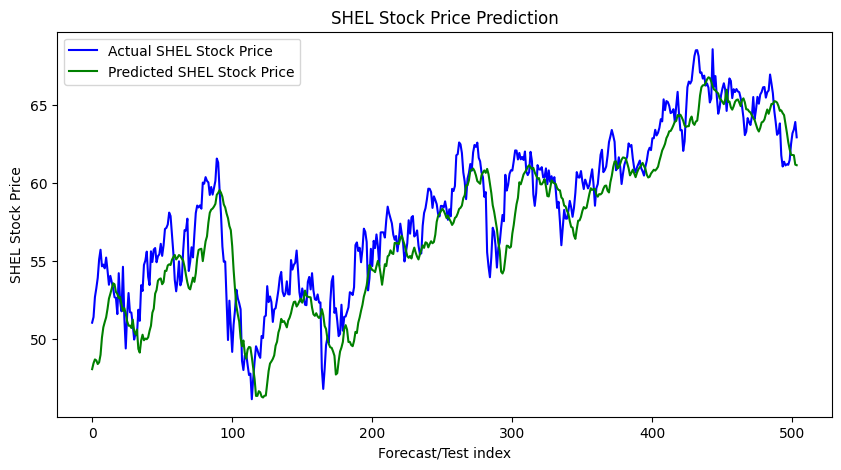

Prediction Performance Metrics on test data:
MAPE is  3.36 %
R2 Score is  0.76


In [86]:
evaluate(model_4, shel_test_std, shel_test_ts_std, shel_scaler_std, 'SHEL')

In [87]:
evaluate(model_4, xom_test_std, xom_test_ts_std, xom_scaler_std, 'XOM')

Prediction Performance Metrics on test data:
MAPE is  4.2 %
R2 Score is  0.77


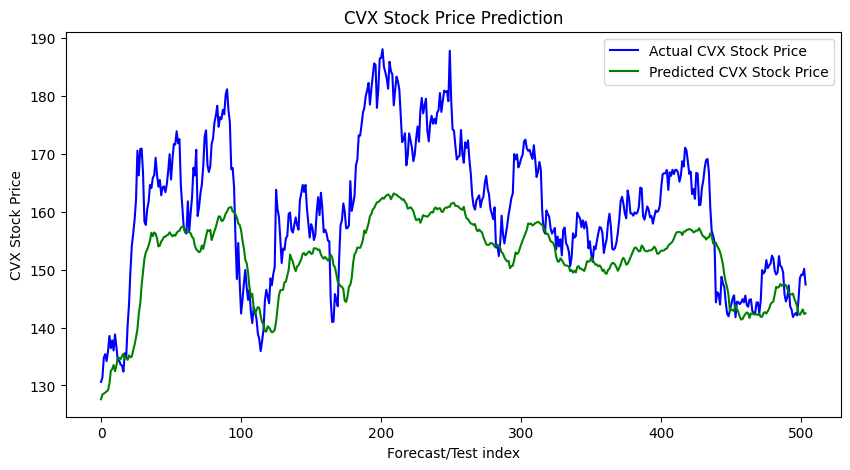

Prediction Performance Metrics on test data:
MAPE is  5.51 %
R2 Score is  0.16


In [88]:
evaluate(model_4, cvx_test_std, cvx_test_ts_std, cvx_scaler_std, 'CVX')

In [89]:
model_4.compile(optimizer='adam', loss='mean_squared_error')

In [90]:
model_4.fit(bp_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 4s - loss: 0.0967 - 4s/epoch - 54ms/step
Epoch 2/20
79/79 - 1s - loss: 0.0860 - 1s/epoch - 17ms/step
Epoch 3/20
79/79 - 1s - loss: 0.0853 - 973ms/epoch - 12ms/step
Epoch 4/20
79/79 - 1s - loss: 0.0784 - 958ms/epoch - 12ms/step
Epoch 5/20
79/79 - 1s - loss: 0.0767 - 925ms/epoch - 12ms/step
Epoch 6/20
79/79 - 1s - loss: 0.0736 - 894ms/epoch - 11ms/step
Epoch 7/20
79/79 - 1s - loss: 0.0755 - 1s/epoch - 13ms/step
Epoch 8/20
79/79 - 1s - loss: 0.0738 - 919ms/epoch - 12ms/step
Epoch 9/20
79/79 - 1s - loss: 0.0758 - 954ms/epoch - 12ms/step
Epoch 10/20
79/79 - 1s - loss: 0.0711 - 918ms/epoch - 12ms/step
Epoch 11/20
79/79 - 1s - loss: 0.0635 - 1s/epoch - 15ms/step
Epoch 12/20
79/79 - 1s - loss: 0.0632 - 1s/epoch - 18ms/step
Epoch 13/20
79/79 - 1s - loss: 0.0640 - 955ms/epoch - 12ms/step
Epoch 14/20
79/79 - 1s - loss: 0.0617 - 905ms/epoch - 11ms/step
Epoch 15/20
79/79 - 1s - loss: 0.0639 - 905ms/epoch - 11ms/step
Epoch 16/20
79/79 - 1s - loss: 0.0642 - 1s/epoch - 14ms/step
Epo

In [91]:
forecast(model_4, bp_forecast, bp_test_std, bp_scaler_std, look_back, 'BP')

Forecast Performance for 1 day:
MAPE is  2.53 %
Forecast Performance for 15 day:
MAPE is  4.34 %
R2 Score is  -7.67
Forecast Performance for 30 day:
MAPE is  5.2 %
R2 Score is  -13.41


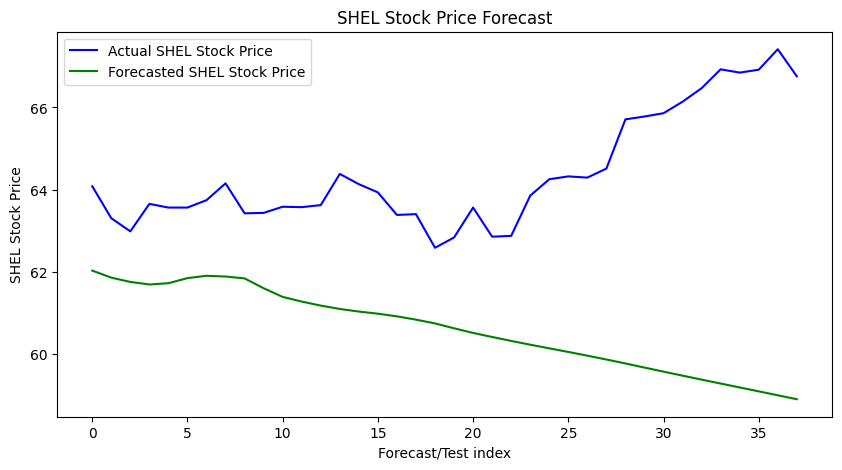

Forecast Performance for 1 day:
MAPE is  3.21 %
Forecast Performance for 15 day:
MAPE is  3.26 %
R2 Score is  -35.44
Forecast Performance for 30 day:
MAPE is  4.39 %
R2 Score is  -17.23


In [92]:
forecast(model_4, shel_forecast, shel_test_std, shel_scaler_std, look_back, 'SHEL')

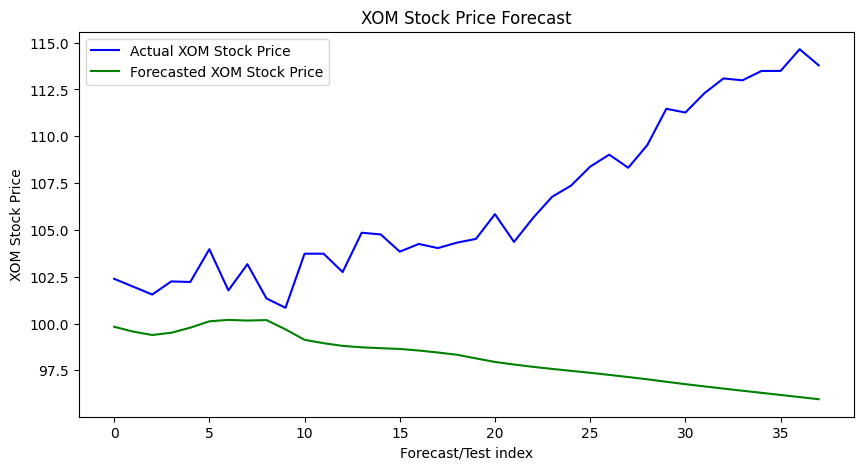

Forecast Performance for 1 day:
MAPE is  2.5 %
Forecast Performance for 15 day:
MAPE is  3.13 %
R2 Score is  -8.06
Forecast Performance for 30 day:
MAPE is  5.65 %
R2 Score is  -6.05


In [93]:
forecast(model_4, xom_forecast, xom_test_std, xom_scaler_std, look_back, 'XOM')

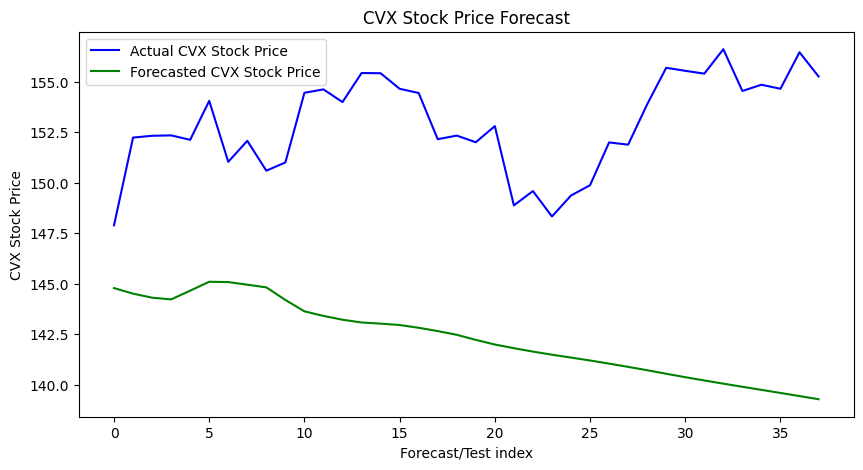

Forecast Performance for 1 day:
MAPE is  2.1 %
Forecast Performance for 15 day:
MAPE is  5.51 %
R2 Score is  -18.61
Forecast Performance for 30 day:
MAPE is  6.09 %
R2 Score is  -19.57


In [94]:
forecast(model_4, cvx_forecast, cvx_test_std, cvx_scaler_std, look_back, 'CVX')

In [95]:
model_4.compile(optimizer='adam', loss='mean_squared_error')

In [96]:
model_4.fit(bp_train_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 4s - loss: 0.0187 - 4s/epoch - 60ms/step
Epoch 2/20
63/63 - 1s - loss: 0.0143 - 719ms/epoch - 11ms/step
Epoch 3/20
63/63 - 1s - loss: 0.0127 - 761ms/epoch - 12ms/step
Epoch 4/20
63/63 - 1s - loss: 0.0115 - 805ms/epoch - 13ms/step
Epoch 5/20
63/63 - 1s - loss: 0.0112 - 725ms/epoch - 12ms/step
Epoch 6/20
63/63 - 1s - loss: 0.0105 - 776ms/epoch - 12ms/step
Epoch 7/20
63/63 - 1s - loss: 0.0103 - 1s/epoch - 18ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0092 - 844ms/epoch - 13ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0098 - 714ms/epoch - 11ms/step
Epoch 10/20
63/63 - 1s - loss: 0.0088 - 725ms/epoch - 12ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0091 - 715ms/epoch - 11ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0086 - 728ms/epoch - 12ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0080 - 713ms/epoch - 11ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0074 - 759ms/epoch - 12ms/step
Epoch 15/20
63/63 - 1s - loss: 0.0079 - 794ms/epoch - 13ms/step
Epoch 16/20
63/63 - 1s - loss: 0.0079 - 727ms/epoch - 1

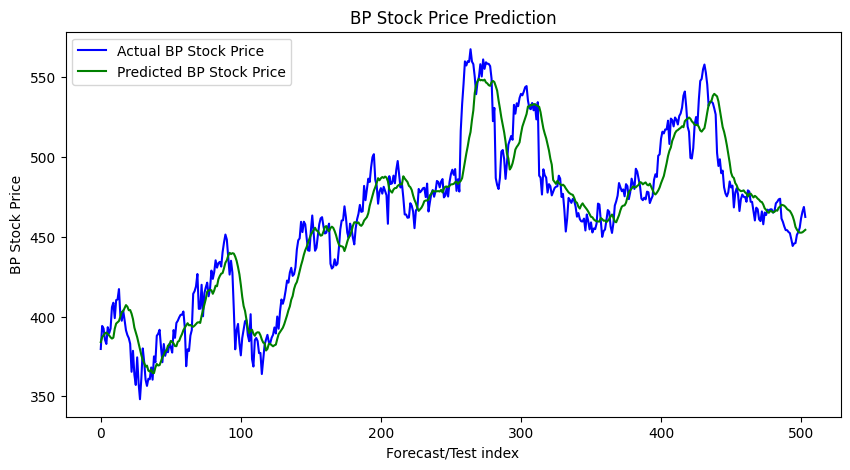

Prediction Performance Metrics on test data:
MAPE is  2.76 %
R2 Score is  0.88


In [97]:
evaluate(model_4, bp_test_min, bp_test_ts_min, bp_scaler_min, 'BP')

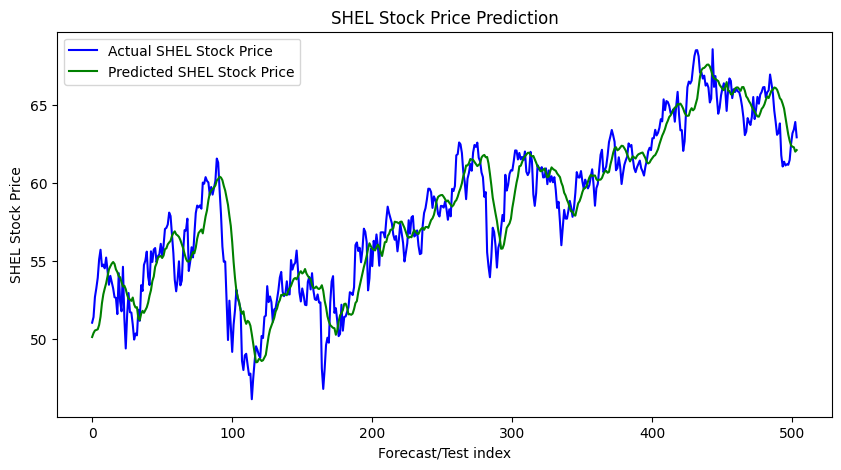

Prediction Performance Metrics on test data:
MAPE is  2.52 %
R2 Score is  0.85


In [98]:
evaluate(model_4, shel_test_min, shel_test_ts_min, shel_scaler_min, 'SHEL')

In [99]:
evaluate(model_4, xom_test_min, xom_test_ts_min, xom_scaler_min, 'XOM')

Prediction Performance Metrics on test data:
MAPE is  3.04 %
R2 Score is  0.88


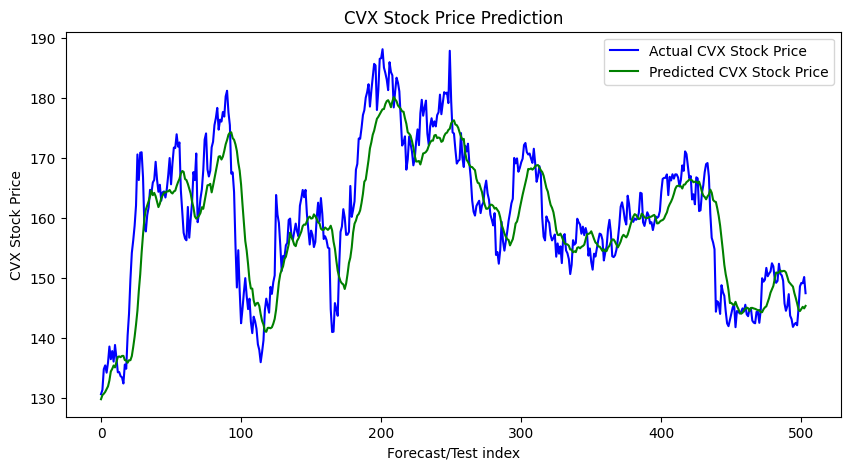

Prediction Performance Metrics on test data:
MAPE is  2.94 %
R2 Score is  0.73


In [100]:
evaluate(model_4, cvx_test_min, cvx_test_ts_min, cvx_scaler_min, 'CVX')

In [101]:
model_4.compile(optimizer='adam', loss='mean_squared_error')

In [102]:
model_4.fit(bp_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 4s - loss: 0.0061 - 4s/epoch - 49ms/step
Epoch 2/20
79/79 - 1s - loss: 0.0061 - 938ms/epoch - 12ms/step
Epoch 3/20
79/79 - 1s - loss: 0.0055 - 914ms/epoch - 12ms/step
Epoch 4/20
79/79 - 1s - loss: 0.0056 - 924ms/epoch - 12ms/step
Epoch 5/20
79/79 - 1s - loss: 0.0051 - 917ms/epoch - 12ms/step
Epoch 6/20
79/79 - 1s - loss: 0.0052 - 1s/epoch - 14ms/step
Epoch 7/20
79/79 - 1s - loss: 0.0050 - 1s/epoch - 18ms/step
Epoch 8/20
79/79 - 1s - loss: 0.0050 - 948ms/epoch - 12ms/step
Epoch 9/20
79/79 - 1s - loss: 0.0048 - 931ms/epoch - 12ms/step
Epoch 10/20
79/79 - 1s - loss: 0.0049 - 934ms/epoch - 12ms/step
Epoch 11/20
79/79 - 1s - loss: 0.0047 - 907ms/epoch - 11ms/step
Epoch 12/20
79/79 - 1s - loss: 0.0045 - 901ms/epoch - 11ms/step
Epoch 13/20
79/79 - 1s - loss: 0.0043 - 919ms/epoch - 12ms/step
Epoch 14/20
79/79 - 1s - loss: 0.0045 - 933ms/epoch - 12ms/step
Epoch 15/20
79/79 - 1s - loss: 0.0043 - 1s/epoch - 13ms/step
Epoch 16/20
79/79 - 2s - loss: 0.0038 - 2s/epoch - 19ms/step


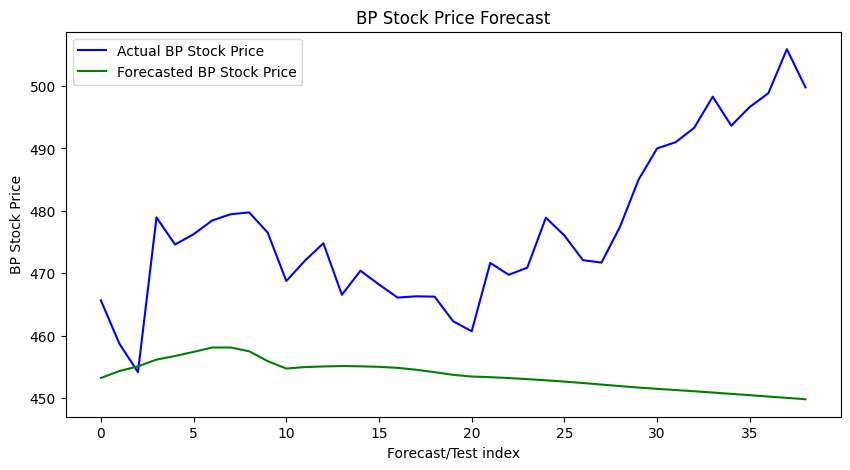

Forecast Performance for 1 day:
MAPE is  2.67 %
Forecast Performance for 15 day:
MAPE is  3.36 %
R2 Score is  -4.27
Forecast Performance for 30 day:
MAPE is  3.54 %
R2 Score is  -5.87


In [103]:
forecast(model_4, bp_forecast, bp_test_min, bp_scaler_min, look_back, 'BP')

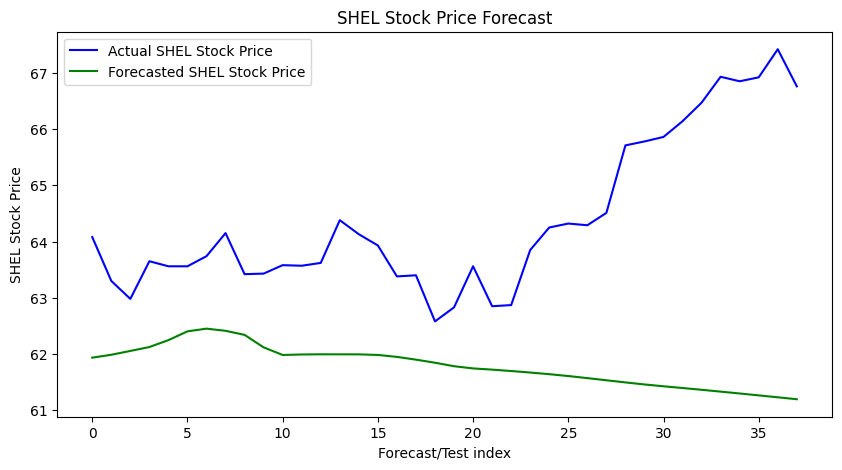

Forecast Performance for 1 day:
MAPE is  3.35 %
Forecast Performance for 15 day:
MAPE is  2.42 %
R2 Score is  -19.07
Forecast Performance for 30 day:
MAPE is  2.89 %
R2 Score is  -7.08


In [104]:
forecast(model_4, shel_forecast, shel_test_min, shel_scaler_min, look_back, 'SHEL')

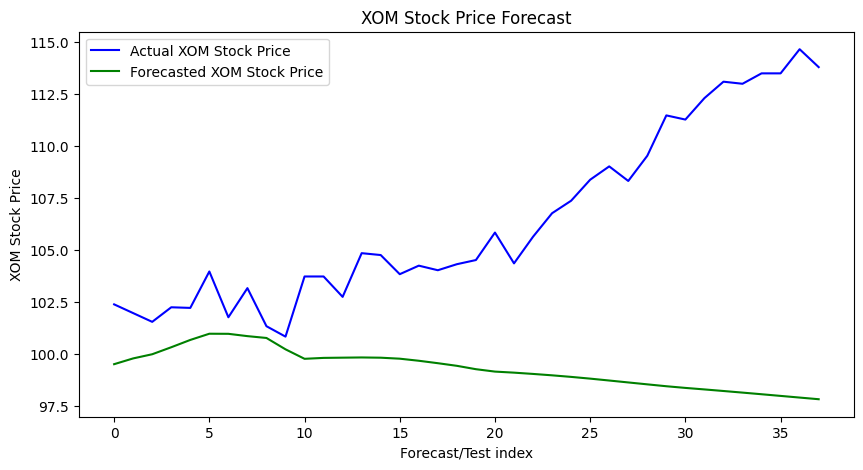

Forecast Performance for 1 day:
MAPE is  2.81 %
Forecast Performance for 15 day:
MAPE is  2.46 %
R2 Score is  -4.9
Forecast Performance for 30 day:
MAPE is  4.69 %
R2 Score is  -4.12


In [105]:
forecast(model_4, xom_forecast, xom_test_min, xom_scaler_min, look_back, 'XOM')

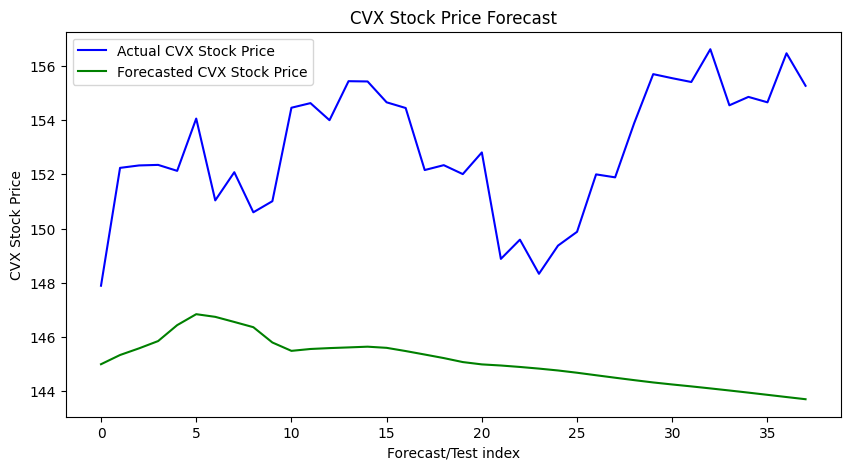

Forecast Performance for 1 day:
MAPE is  1.96 %
Forecast Performance for 15 day:
MAPE is  4.41 %
R2 Score is  -11.56
Forecast Performance for 30 day:
MAPE is  4.49 %
R2 Score is  -10.41


In [106]:
forecast(model_4, cvx_forecast, cvx_test_min, cvx_scaler_min, look_back, 'CVX')

###Model-5 Building and Evaluation

In [107]:
#Model 5 - BILSTM layer
model_5 = Sequential()
model_5.add(Bidirectional(LSTM(units=50, return_sequences=False, input_shape=(look_back, 1))))
model_5.add(Dense(units=1))


model_5.compile(optimizer='adam', loss='mean_squared_error')

In [108]:
model_5.fit(bp_train_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 6s - loss: 0.2466 - 6s/epoch - 96ms/step
Epoch 2/20
63/63 - 1s - loss: 0.0417 - 606ms/epoch - 10ms/step
Epoch 3/20
63/63 - 1s - loss: 0.0338 - 598ms/epoch - 9ms/step
Epoch 4/20
63/63 - 1s - loss: 0.0371 - 602ms/epoch - 10ms/step
Epoch 5/20
63/63 - 1s - loss: 0.0328 - 614ms/epoch - 10ms/step
Epoch 6/20
63/63 - 1s - loss: 0.0276 - 598ms/epoch - 9ms/step
Epoch 7/20
63/63 - 1s - loss: 0.0264 - 610ms/epoch - 10ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0252 - 603ms/epoch - 10ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0238 - 611ms/epoch - 10ms/step
Epoch 10/20
63/63 - 1s - loss: 0.0240 - 634ms/epoch - 10ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0197 - 608ms/epoch - 10ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0213 - 603ms/epoch - 10ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0184 - 855ms/epoch - 14ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0249 - 1s/epoch - 17ms/step
Epoch 15/20
63/63 - 1s - loss: 0.0184 - 607ms/epoch - 10ms/step
Epoch 16/20
63/63 - 1s - loss: 0.0182 - 623ms/epoch - 10m

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20901 (81.64 KB)
Trainable params: 20901 (81.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


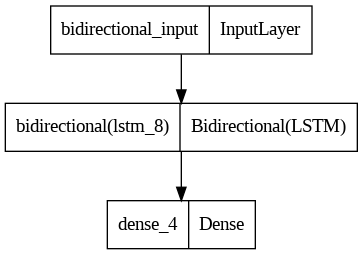

In [109]:
model_5.summary()
plot_model(model_5)

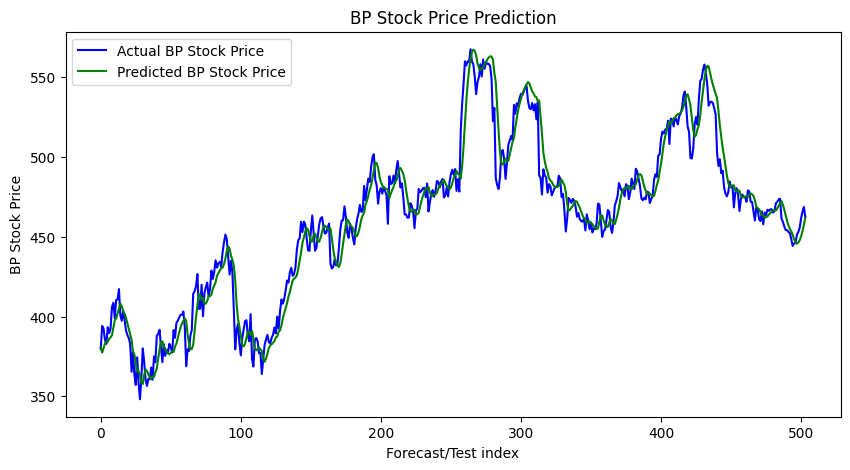

Prediction Performance Metrics on test data:
MAPE is  1.94 %
R2 Score is  0.94


In [110]:
evaluate(model_5, bp_test_std, bp_test_ts_std, bp_scaler_std, 'BP')

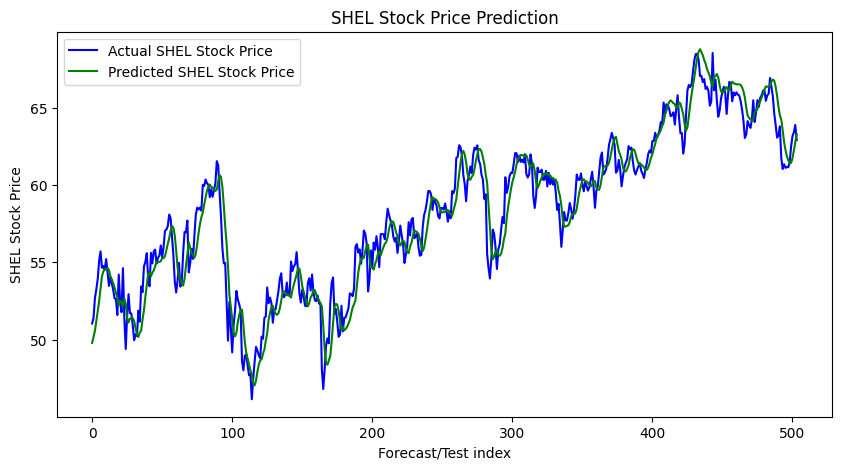

Prediction Performance Metrics on test data:
MAPE is  1.87 %
R2 Score is  0.92


In [111]:
evaluate(model_5, shel_test_std, shel_test_ts_std, shel_scaler_std, 'SHEL')

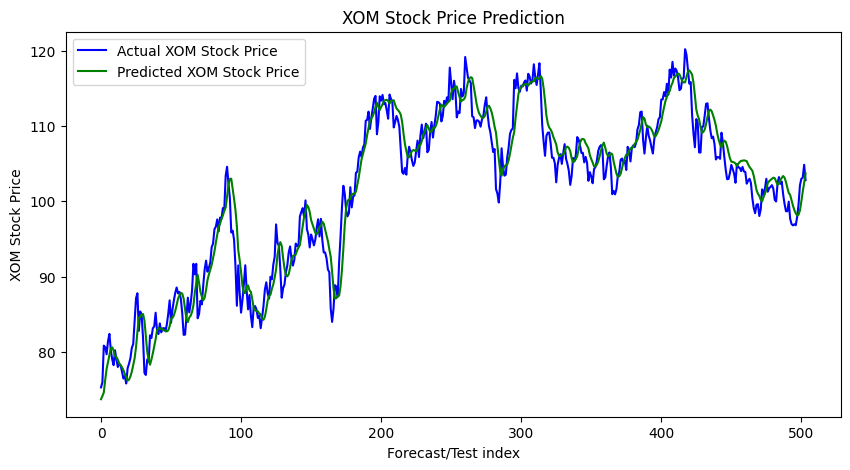

Prediction Performance Metrics on test data:
MAPE is  2.1 %
R2 Score is  0.94


In [112]:
evaluate(model_5, xom_test_std, xom_test_ts_std, xom_scaler_std, 'XOM')

In [113]:
evaluate(model_5, cvx_test_std, cvx_test_ts_std, cvx_scaler_std, 'CVX')

Prediction Performance Metrics on test data:
MAPE is  2.08 %
R2 Score is  0.87


In [114]:
model_5.compile(optimizer='adam', loss='mean_squared_error')

In [115]:
model_5.fit(bp_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 5s - loss: 0.0166 - 5s/epoch - 62ms/step
Epoch 2/20
79/79 - 1s - loss: 0.0134 - 1s/epoch - 17ms/step
Epoch 3/20
79/79 - 1s - loss: 0.0142 - 883ms/epoch - 11ms/step
Epoch 4/20
79/79 - 1s - loss: 0.0154 - 796ms/epoch - 10ms/step
Epoch 5/20
79/79 - 1s - loss: 0.0119 - 817ms/epoch - 10ms/step
Epoch 6/20
79/79 - 1s - loss: 0.0115 - 796ms/epoch - 10ms/step
Epoch 7/20
79/79 - 1s - loss: 0.0113 - 807ms/epoch - 10ms/step
Epoch 8/20
79/79 - 1s - loss: 0.0118 - 812ms/epoch - 10ms/step
Epoch 9/20
79/79 - 1s - loss: 0.0149 - 782ms/epoch - 10ms/step
Epoch 10/20
79/79 - 1s - loss: 0.0099 - 768ms/epoch - 10ms/step
Epoch 11/20
79/79 - 1s - loss: 0.0096 - 862ms/epoch - 11ms/step
Epoch 12/20
79/79 - 1s - loss: 0.0098 - 1s/epoch - 17ms/step
Epoch 13/20
79/79 - 1s - loss: 0.0094 - 1s/epoch - 16ms/step
Epoch 14/20
79/79 - 1s - loss: 0.0089 - 763ms/epoch - 10ms/step
Epoch 15/20
79/79 - 1s - loss: 0.0145 - 788ms/epoch - 10ms/step
Epoch 16/20
79/79 - 1s - loss: 0.0099 - 739ms/epoch - 9ms/ste

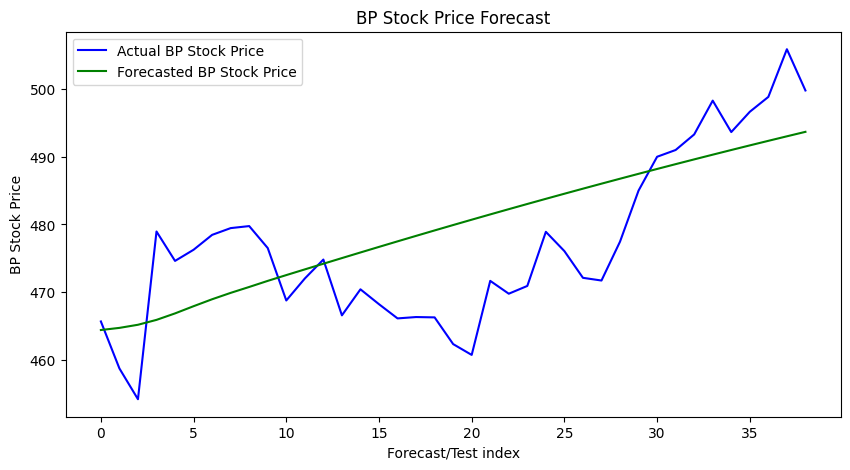

Forecast Performance for 1 day:
MAPE is  0.27 %
Forecast Performance for 15 day:
MAPE is  1.41 %
R2 Score is  -0.03
Forecast Performance for 30 day:
MAPE is  1.91 %
R2 Score is  -1.14


In [116]:
forecast(model_5, bp_forecast, bp_test_std, bp_scaler_std, look_back, 'BP')

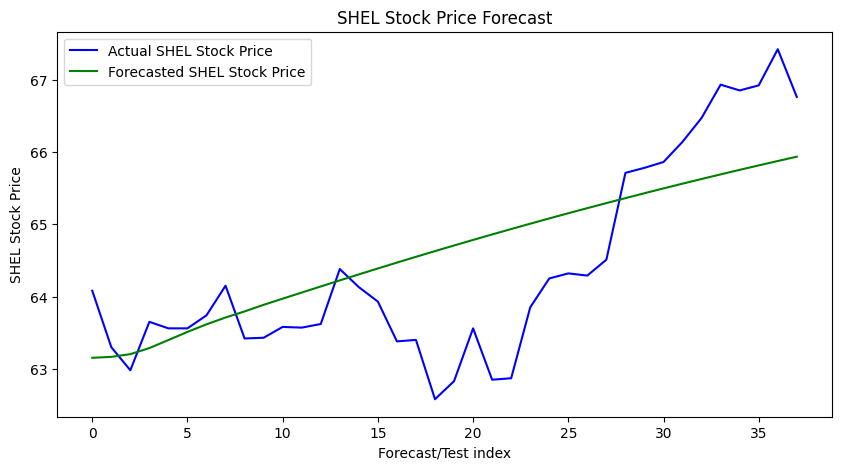

Forecast Performance for 1 day:
MAPE is  1.45 %
Forecast Performance for 15 day:
MAPE is  0.52 %
R2 Score is  -0.24
Forecast Performance for 30 day:
MAPE is  1.16 %
R2 Score is  -0.74


In [117]:
forecast(model_5, shel_forecast, shel_test_std, shel_scaler_std, look_back, 'SHEL')

In [118]:
forecast(model_5, xom_forecast, xom_test_std, xom_scaler_std, look_back, 'XOM')

Forecast Performance for 1 day:
MAPE is  -0.69 %
Forecast Performance for 15 day:
MAPE is  1.15 %
R2 Score is  -0.26
Forecast Performance for 30 day:
MAPE is  2.68 %
R2 Score is  -1.05


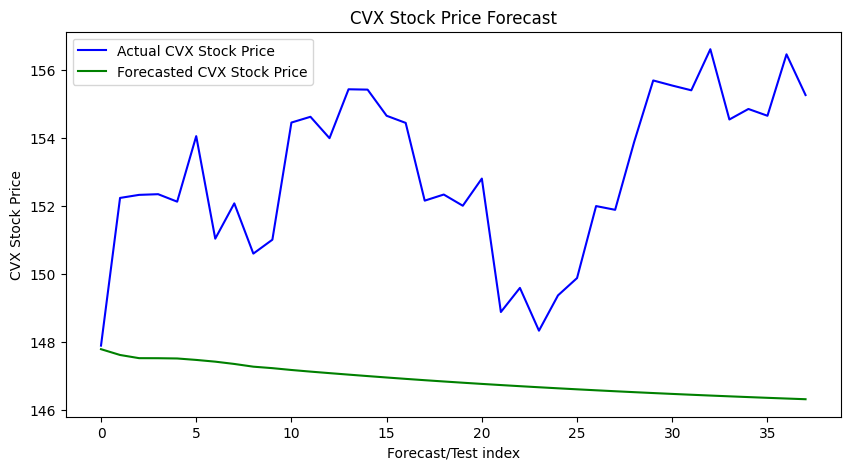

Forecast Performance for 1 day:
MAPE is  0.07 %
Forecast Performance for 15 day:
MAPE is  3.46 %
R2 Score is  -7.26
Forecast Performance for 30 day:
MAPE is  3.42 %
R2 Score is  -6.1


In [119]:
forecast(model_5, cvx_forecast, cvx_test_std, cvx_scaler_std, look_back, 'CVX')

In [120]:
model_5.compile(optimizer='adam', loss='mean_squared_error')

In [121]:
model_5.fit(bp_train_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 5s - loss: 4.5312e-04 - 5s/epoch - 83ms/step
Epoch 2/20
63/63 - 1s - loss: 4.1125e-04 - 621ms/epoch - 10ms/step
Epoch 3/20
63/63 - 1s - loss: 4.0580e-04 - 605ms/epoch - 10ms/step
Epoch 4/20
63/63 - 1s - loss: 4.1224e-04 - 629ms/epoch - 10ms/step
Epoch 5/20
63/63 - 1s - loss: 4.1353e-04 - 706ms/epoch - 11ms/step
Epoch 6/20
63/63 - 1s - loss: 3.8469e-04 - 727ms/epoch - 12ms/step
Epoch 7/20
63/63 - 1s - loss: 3.5391e-04 - 636ms/epoch - 10ms/step
Epoch 8/20
63/63 - 1s - loss: 3.9830e-04 - 631ms/epoch - 10ms/step
Epoch 9/20
63/63 - 1s - loss: 4.0649e-04 - 1s/epoch - 17ms/step
Epoch 10/20
63/63 - 1s - loss: 4.0501e-04 - 1s/epoch - 18ms/step
Epoch 11/20
63/63 - 1s - loss: 5.1472e-04 - 830ms/epoch - 13ms/step
Epoch 12/20
63/63 - 1s - loss: 3.7951e-04 - 621ms/epoch - 10ms/step
Epoch 13/20
63/63 - 1s - loss: 3.4552e-04 - 666ms/epoch - 11ms/step
Epoch 14/20
63/63 - 1s - loss: 3.6828e-04 - 665ms/epoch - 11ms/step
Epoch 15/20
63/63 - 1s - loss: 3.5736e-04 - 629ms/epoch - 10ms/ste

In [122]:
evaluate(model_5, bp_test_min, bp_test_ts_min, bp_scaler_min, 'BP')

Prediction Performance Metrics on test data:
MAPE is  1.75 %
R2 Score is  0.96


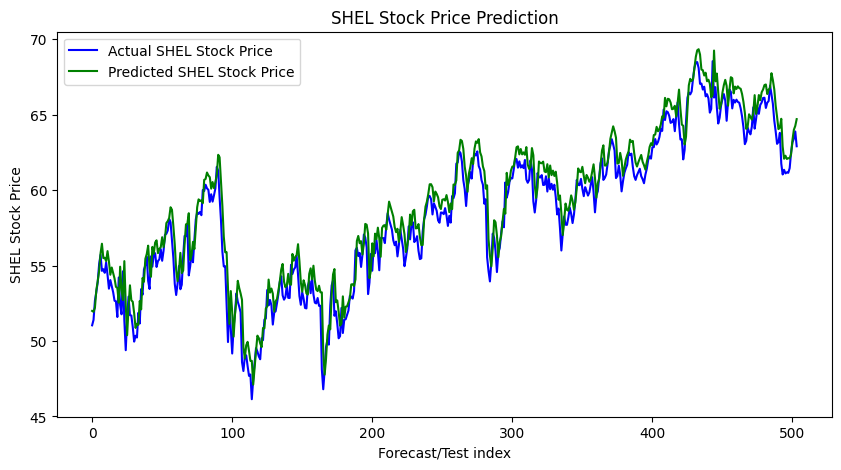

Prediction Performance Metrics on test data:
MAPE is  1.83 %
R2 Score is  0.93


In [123]:
evaluate(model_5, shel_test_min, shel_test_ts_min, shel_scaler_min, 'SHEL')

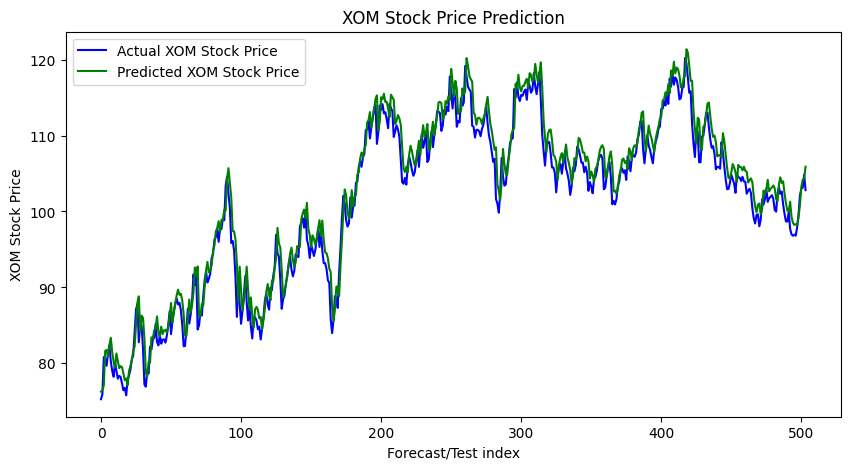

Prediction Performance Metrics on test data:
MAPE is  1.8 %
R2 Score is  0.96


In [124]:
evaluate(model_5, xom_test_min, xom_test_ts_min, xom_scaler_min, 'XOM')

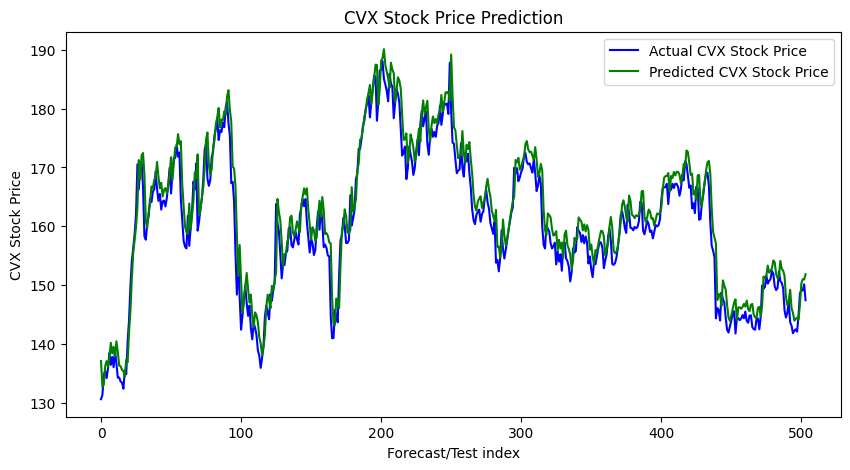

Prediction Performance Metrics on test data:
MAPE is  1.71 %
R2 Score is  0.91


In [125]:
evaluate(model_5, cvx_test_min, cvx_test_ts_min, cvx_scaler_min, 'CVX')

In [126]:
model_5.compile(optimizer='adam', loss='mean_squared_error')

In [127]:
model_5.fit(bp_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 7s - loss: 4.6922e-04 - 7s/epoch - 83ms/step
Epoch 2/20
79/79 - 1s - loss: 4.3351e-04 - 772ms/epoch - 10ms/step
Epoch 3/20
79/79 - 1s - loss: 3.7341e-04 - 774ms/epoch - 10ms/step
Epoch 4/20
79/79 - 1s - loss: 3.7096e-04 - 772ms/epoch - 10ms/step
Epoch 5/20
79/79 - 1s - loss: 4.0222e-04 - 868ms/epoch - 11ms/step
Epoch 6/20
79/79 - 1s - loss: 3.9091e-04 - 816ms/epoch - 10ms/step
Epoch 7/20
79/79 - 1s - loss: 3.7182e-04 - 793ms/epoch - 10ms/step
Epoch 8/20
79/79 - 1s - loss: 4.1093e-04 - 835ms/epoch - 11ms/step
Epoch 9/20
79/79 - 1s - loss: 3.8814e-04 - 1s/epoch - 17ms/step
Epoch 10/20
79/79 - 1s - loss: 3.8811e-04 - 881ms/epoch - 11ms/step
Epoch 11/20
79/79 - 1s - loss: 3.6568e-04 - 793ms/epoch - 10ms/step
Epoch 12/20
79/79 - 1s - loss: 4.4595e-04 - 816ms/epoch - 10ms/step
Epoch 13/20
79/79 - 1s - loss: 4.1096e-04 - 810ms/epoch - 10ms/step
Epoch 14/20
79/79 - 1s - loss: 3.8666e-04 - 803ms/epoch - 10ms/step
Epoch 15/20
79/79 - 1s - loss: 3.9239e-04 - 889ms/epoch - 11ms/

In [128]:
forecast(model_5, bp_forecast, bp_test_min, bp_scaler_min, look_back, 'BP')

Forecast Performance for 1 day:
MAPE is  0.39 %
Forecast Performance for 15 day:
MAPE is  1.55 %
R2 Score is  -0.21
Forecast Performance for 30 day:
MAPE is  3.14 %
R2 Score is  -5.08


In [129]:
forecast(model_5, shel_forecast, shel_test_min, shel_scaler_min, look_back, 'SHEL')

Forecast Performance for 1 day:
MAPE is  1.5 %
Forecast Performance for 15 day:
MAPE is  1.57 %
R2 Score is  -10.28
Forecast Performance for 30 day:
MAPE is  3.67 %
R2 Score is  -13.9


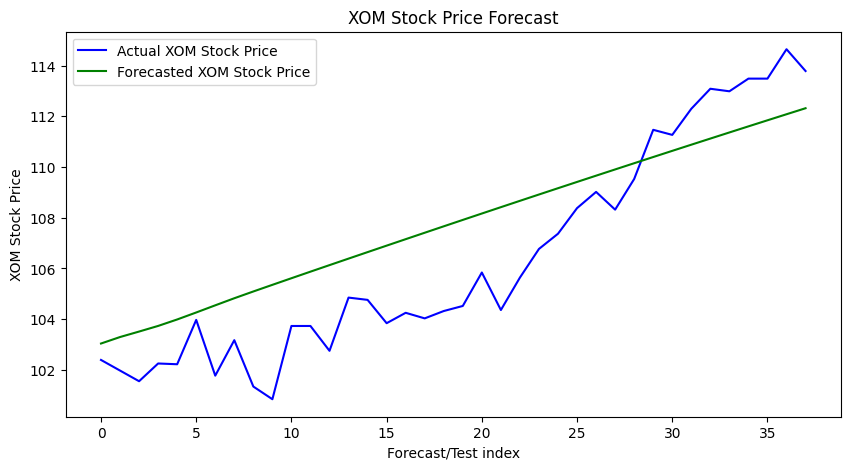

Forecast Performance for 1 day:
MAPE is  -0.63 %
Forecast Performance for 15 day:
MAPE is  2.02 %
R2 Score is  -2.83
Forecast Performance for 30 day:
MAPE is  2.1 %
R2 Score is  0.14


In [130]:
forecast(model_5, xom_forecast, xom_test_min, xom_scaler_min, look_back, 'XOM')

In [131]:
forecast(model_5, cvx_forecast, cvx_test_min, cvx_scaler_min, look_back, 'CVX')

Forecast Performance for 1 day:
MAPE is  0.03 %
Forecast Performance for 15 day:
MAPE is  1.29 %
R2 Score is  -0.39
Forecast Performance for 30 day:
MAPE is  2.46 %
R2 Score is  -3.84


###Model-6 Building and Evaluation

In [132]:
#Model 6 - BI-GRU layer
model_6 = Sequential()
model_6.add(Bidirectional(GRU(units=50, return_sequences=False, input_shape=(look_back, 1))))
model_6.add(Dense(units=1))


model_6.compile(optimizer='adam', loss='mean_squared_error')

In [133]:
model_6.fit(bp_train_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 5s - loss: 0.1453 - 5s/epoch - 87ms/step
Epoch 2/20
63/63 - 1s - loss: 0.0252 - 1s/epoch - 17ms/step
Epoch 3/20
63/63 - 1s - loss: 0.0227 - 1s/epoch - 17ms/step
Epoch 4/20
63/63 - 1s - loss: 0.0207 - 651ms/epoch - 10ms/step
Epoch 5/20
63/63 - 1s - loss: 0.0193 - 623ms/epoch - 10ms/step
Epoch 6/20
63/63 - 1s - loss: 0.0161 - 646ms/epoch - 10ms/step
Epoch 7/20
63/63 - 1s - loss: 0.0159 - 655ms/epoch - 10ms/step
Epoch 8/20
63/63 - 1s - loss: 0.0142 - 645ms/epoch - 10ms/step
Epoch 9/20
63/63 - 1s - loss: 0.0127 - 726ms/epoch - 12ms/step
Epoch 10/20
63/63 - 1s - loss: 0.0118 - 660ms/epoch - 10ms/step
Epoch 11/20
63/63 - 1s - loss: 0.0108 - 641ms/epoch - 10ms/step
Epoch 12/20
63/63 - 1s - loss: 0.0111 - 709ms/epoch - 11ms/step
Epoch 13/20
63/63 - 1s - loss: 0.0109 - 649ms/epoch - 10ms/step
Epoch 14/20
63/63 - 1s - loss: 0.0099 - 661ms/epoch - 10ms/step
Epoch 15/20
63/63 - 1s - loss: 0.0096 - 1s/epoch - 18ms/step
Epoch 16/20
63/63 - 1s - loss: 0.0096 - 961ms/epoch - 15ms/st

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 100)               15900     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 16001 (62.50 KB)
Trainable params: 16001 (62.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


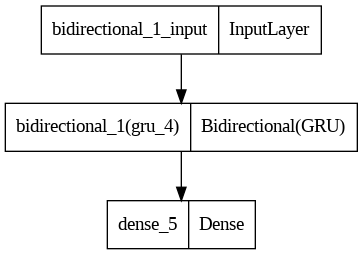

In [134]:
model_6.summary()
plot_model(model_6)

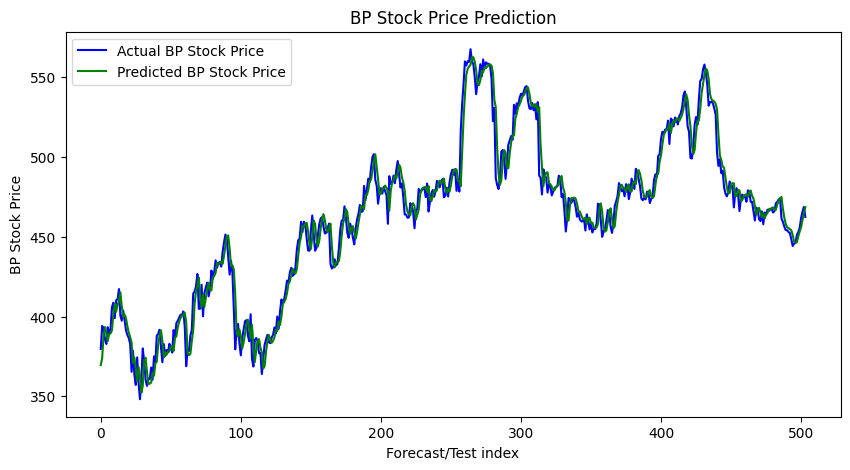

Prediction Performance Metrics on test data:
MAPE is  1.5 %
R2 Score is  0.97


In [135]:
evaluate(model_6, bp_test_std, bp_test_ts_std, bp_scaler_std, 'BP')

In [136]:
evaluate(model_6, shel_test_std, shel_test_ts_std, shel_scaler_std, 'SHEL')

Prediction Performance Metrics on test data:
MAPE is  1.42 %
R2 Score is  0.95


In [137]:
evaluate(model_6, xom_test_std, xom_test_ts_std, xom_scaler_std, 'XOM')

Prediction Performance Metrics on test data:
MAPE is  1.62 %
R2 Score is  0.96


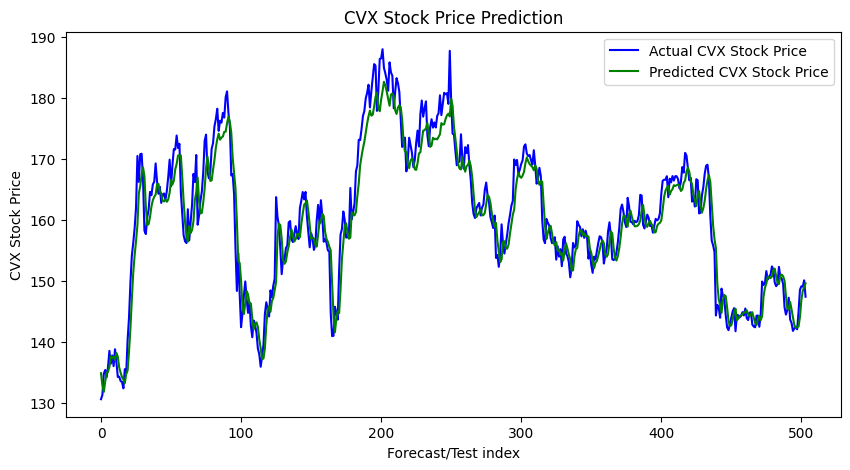

Prediction Performance Metrics on test data:
MAPE is  1.64 %
R2 Score is  0.92


In [138]:
evaluate(model_6, cvx_test_std, cvx_test_ts_std, cvx_scaler_std, 'CVX')

In [139]:
model_6.compile(optimizer='adam', loss='mean_squared_error')

In [140]:
model_6.fit(bp_ts_std, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 5s - loss: 0.0111 - 5s/epoch - 62ms/step
Epoch 2/20
79/79 - 1s - loss: 0.0096 - 1s/epoch - 13ms/step
Epoch 3/20
79/79 - 1s - loss: 0.0093 - 1s/epoch - 17ms/step
Epoch 4/20
79/79 - 1s - loss: 0.0088 - 898ms/epoch - 11ms/step
Epoch 5/20
79/79 - 1s - loss: 0.0086 - 783ms/epoch - 10ms/step
Epoch 6/20
79/79 - 1s - loss: 0.0089 - 805ms/epoch - 10ms/step
Epoch 7/20
79/79 - 1s - loss: 0.0102 - 814ms/epoch - 10ms/step
Epoch 8/20
79/79 - 1s - loss: 0.0089 - 792ms/epoch - 10ms/step
Epoch 9/20
79/79 - 1s - loss: 0.0108 - 807ms/epoch - 10ms/step
Epoch 10/20
79/79 - 1s - loss: 0.0088 - 890ms/epoch - 11ms/step
Epoch 11/20
79/79 - 1s - loss: 0.0082 - 834ms/epoch - 11ms/step
Epoch 12/20
79/79 - 1s - loss: 0.0080 - 829ms/epoch - 10ms/step
Epoch 13/20
79/79 - 1s - loss: 0.0079 - 1s/epoch - 18ms/step
Epoch 14/20
79/79 - 1s - loss: 0.0084 - 932ms/epoch - 12ms/step
Epoch 15/20
79/79 - 1s - loss: 0.0089 - 812ms/epoch - 10ms/step
Epoch 16/20
79/79 - 1s - loss: 0.0087 - 801ms/epoch - 10ms/st

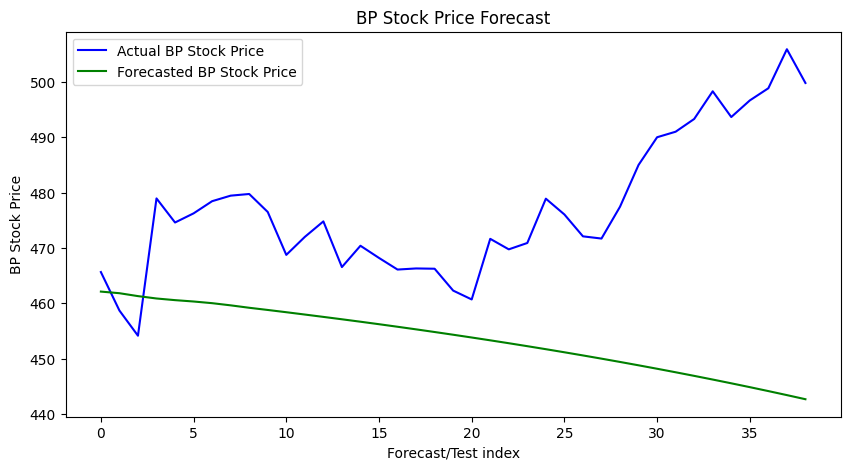

Forecast Performance for 1 day:
MAPE is  0.76 %
Forecast Performance for 15 day:
MAPE is  2.85 %
R2 Score is  -2.83
Forecast Performance for 30 day:
MAPE is  3.35 %
R2 Score is  -5.42


In [141]:
forecast(model_6, bp_forecast, bp_test_std, bp_scaler_std, look_back, 'BP')

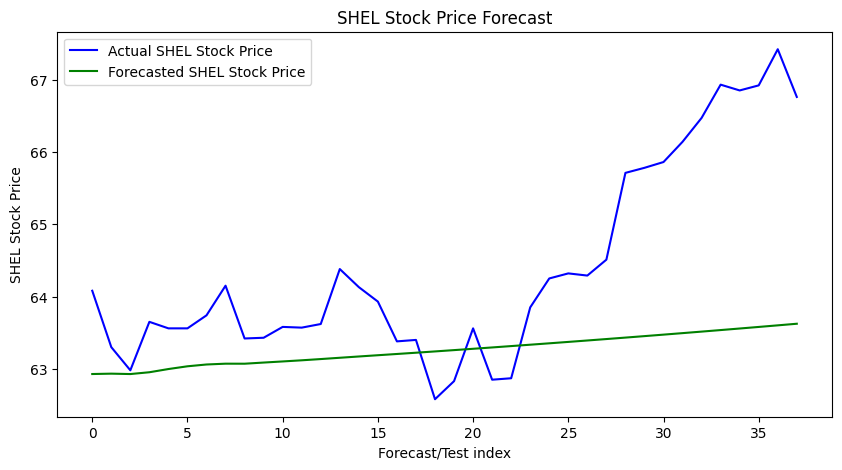

Forecast Performance for 1 day:
MAPE is  1.8 %
Forecast Performance for 15 day:
MAPE is  0.98 %
R2 Score is  -2.95
Forecast Performance for 30 day:
MAPE is  1.13 %
R2 Score is  -0.53


In [142]:
forecast(model_6, shel_forecast, shel_test_std, shel_scaler_std, look_back, 'SHEL')

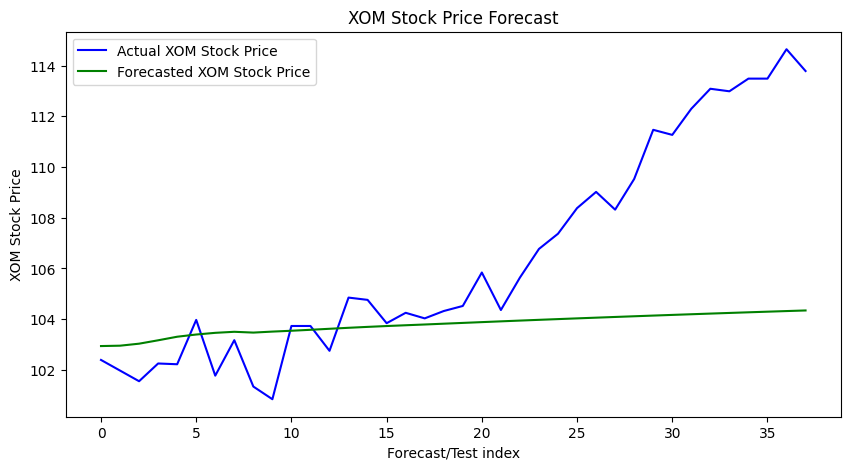

Forecast Performance for 1 day:
MAPE is  -0.53 %
Forecast Performance for 15 day:
MAPE is  1.03 %
R2 Score is  -0.12
Forecast Performance for 30 day:
MAPE is  1.7 %
R2 Score is  0.06


In [143]:
forecast(model_6, xom_forecast, xom_test_std, xom_scaler_std, look_back, 'XOM')

In [144]:
forecast(model_6, cvx_forecast, cvx_test_std, cvx_scaler_std, look_back, 'CVX')

Forecast Performance for 1 day:
MAPE is  0.2 %
Forecast Performance for 15 day:
MAPE is  2.89 %
R2 Score is  -4.76
Forecast Performance for 30 day:
MAPE is  2.4 %
R2 Score is  -2.94


In [145]:
model_6.compile(optimizer='adam', loss='mean_squared_error')

In [146]:
model_6.fit(bp_train_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
63/63 - 5s - loss: 4.3006e-04 - 5s/epoch - 80ms/step
Epoch 2/20
63/63 - 1s - loss: 3.4366e-04 - 612ms/epoch - 10ms/step
Epoch 3/20
63/63 - 1s - loss: 3.4667e-04 - 648ms/epoch - 10ms/step
Epoch 4/20
63/63 - 1s - loss: 3.8677e-04 - 654ms/epoch - 10ms/step
Epoch 5/20
63/63 - 1s - loss: 4.8654e-04 - 619ms/epoch - 10ms/step
Epoch 6/20
63/63 - 1s - loss: 3.4949e-04 - 608ms/epoch - 10ms/step
Epoch 7/20
63/63 - 1s - loss: 3.8519e-04 - 620ms/epoch - 10ms/step
Epoch 8/20
63/63 - 1s - loss: 6.0675e-04 - 611ms/epoch - 10ms/step
Epoch 9/20
63/63 - 1s - loss: 5.1110e-04 - 1s/epoch - 16ms/step
Epoch 10/20
63/63 - 1s - loss: 3.3847e-04 - 1s/epoch - 17ms/step
Epoch 11/20
63/63 - 1s - loss: 3.3462e-04 - 787ms/epoch - 12ms/step
Epoch 12/20
63/63 - 1s - loss: 3.4560e-04 - 620ms/epoch - 10ms/step
Epoch 13/20
63/63 - 1s - loss: 3.6442e-04 - 624ms/epoch - 10ms/step
Epoch 14/20
63/63 - 1s - loss: 3.7272e-04 - 617ms/epoch - 10ms/step
Epoch 15/20
63/63 - 1s - loss: 4.8240e-04 - 618ms/epoch - 10ms/ste

In [147]:
evaluate(model_6, bp_test_min, bp_test_ts_min, bp_scaler_min, 'BP')

Prediction Performance Metrics on test data:
MAPE is  1.4 %
R2 Score is  0.97


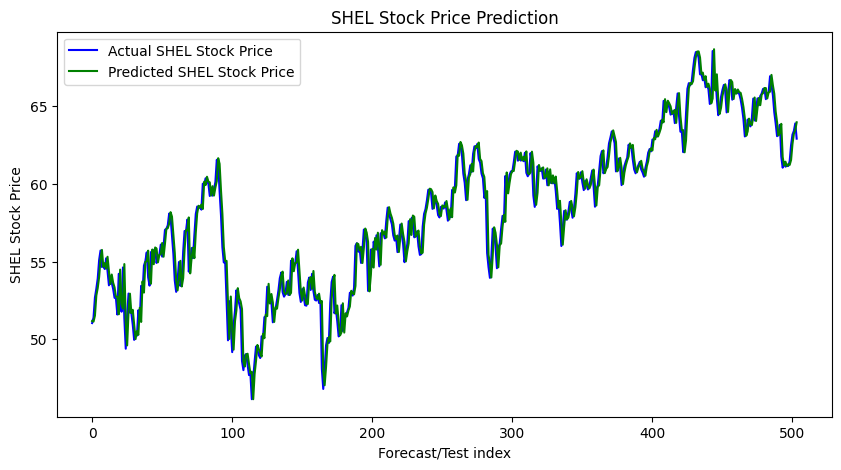

Prediction Performance Metrics on test data:
MAPE is  1.33 %
R2 Score is  0.96


In [148]:
evaluate(model_6, shel_test_min, shel_test_ts_min, shel_scaler_min, 'SHEL')

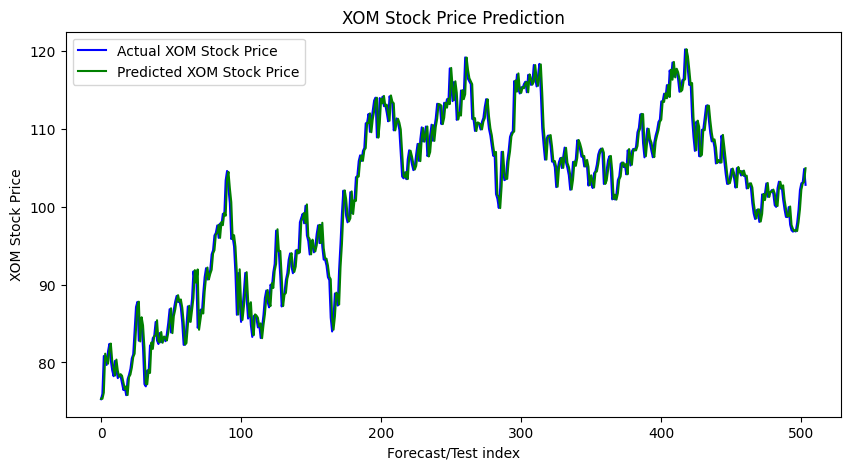

Prediction Performance Metrics on test data:
MAPE is  1.45 %
R2 Score is  0.97


In [149]:
evaluate(model_6, xom_test_min, xom_test_ts_min, xom_scaler_min, 'XOM')

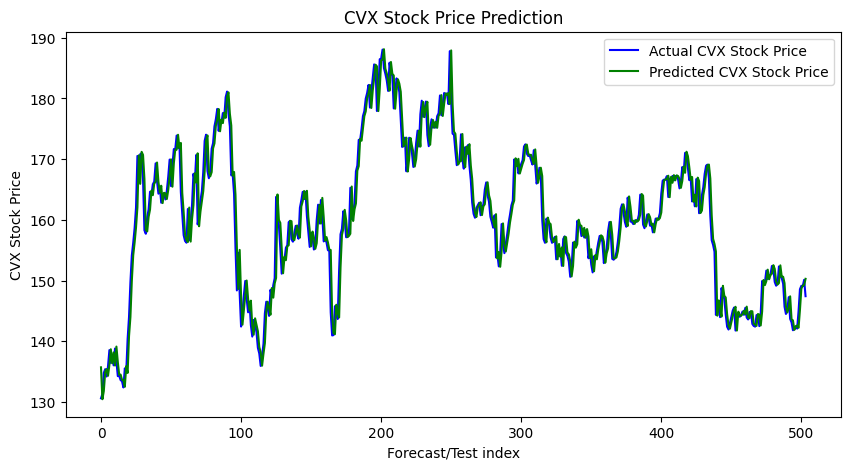

Prediction Performance Metrics on test data:
MAPE is  1.34 %
R2 Score is  0.94


In [150]:
evaluate(model_6, cvx_test_min, cvx_test_ts_min, cvx_scaler_min, 'CVX')

In [151]:
model_6.compile(optimizer='adam', loss='mean_squared_error')

In [152]:
model_6.fit(bp_ts_min, epochs=epoch,batch_size=128, verbose=2)

Epoch 1/20
79/79 - 7s - loss: 4.0265e-04 - 7s/epoch - 82ms/step
Epoch 2/20
79/79 - 1s - loss: 4.2362e-04 - 856ms/epoch - 11ms/step
Epoch 3/20
79/79 - 1s - loss: 3.6649e-04 - 1s/epoch - 13ms/step
Epoch 4/20
79/79 - 2s - loss: 3.8953e-04 - 2s/epoch - 20ms/step
Epoch 5/20
79/79 - 1s - loss: 4.0049e-04 - 1s/epoch - 18ms/step
Epoch 6/20
79/79 - 1s - loss: 4.1750e-04 - 1s/epoch - 13ms/step
Epoch 7/20
79/79 - 1s - loss: 3.9632e-04 - 1s/epoch - 13ms/step
Epoch 8/20
79/79 - 1s - loss: 3.7516e-04 - 1s/epoch - 13ms/step
Epoch 9/20
79/79 - 1s - loss: 3.8800e-04 - 1s/epoch - 14ms/step
Epoch 10/20
79/79 - 1s - loss: 3.9724e-04 - 1s/epoch - 13ms/step
Epoch 11/20
79/79 - 1s - loss: 3.8988e-04 - 1s/epoch - 14ms/step
Epoch 12/20
79/79 - 1s - loss: 3.6153e-04 - 1s/epoch - 14ms/step
Epoch 13/20
79/79 - 1s - loss: 3.8706e-04 - 1s/epoch - 18ms/step
Epoch 14/20
79/79 - 2s - loss: 3.6147e-04 - 2s/epoch - 24ms/step
Epoch 15/20
79/79 - 1s - loss: 3.7705e-04 - 1s/epoch - 14ms/step
Epoch 16/20
79/79 - 1s - loss: 

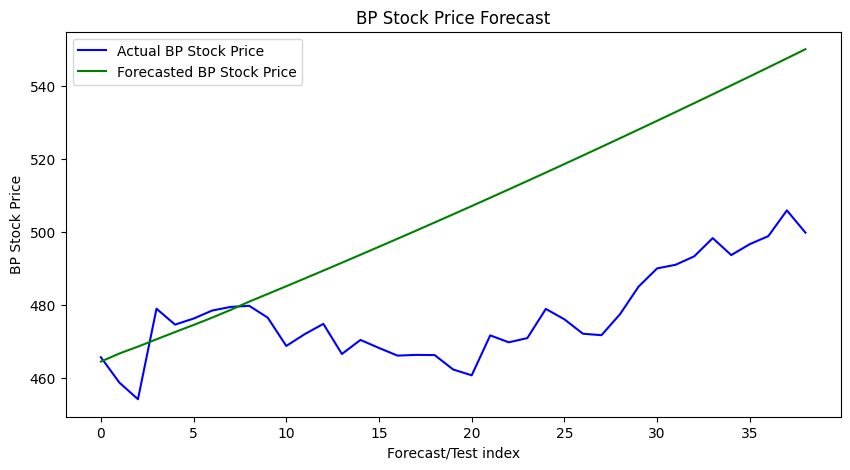

Forecast Performance for 1 day:
MAPE is  0.25 %
Forecast Performance for 15 day:
MAPE is  2.0 %
R2 Score is  -1.73
Forecast Performance for 30 day:
MAPE is  5.34 %
R2 Score is  -18.61


In [153]:
forecast(model_6, bp_forecast, bp_test_min, bp_scaler_min, look_back, 'BP')

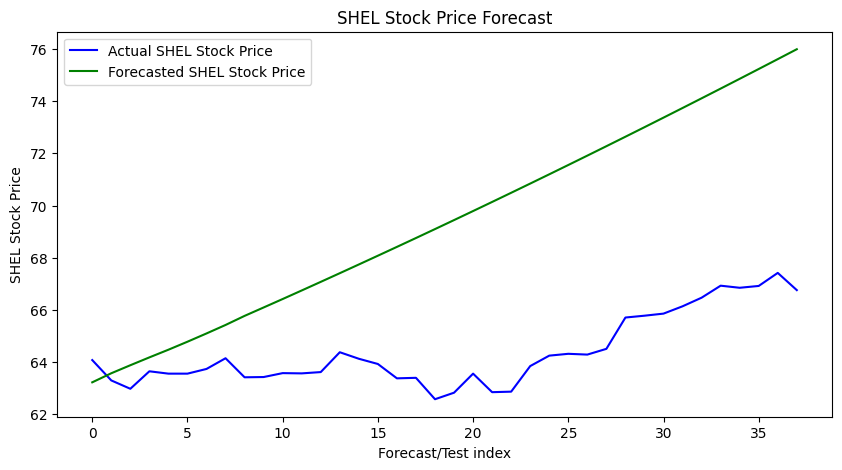

Forecast Performance for 1 day:
MAPE is  1.33 %
Forecast Performance for 15 day:
MAPE is  2.98 %
R2 Score is  -37.32
Forecast Performance for 30 day:
MAPE is  6.68 %
R2 Score is  -47.26


In [154]:
forecast(model_6, shel_forecast, shel_test_min, shel_scaler_min, look_back, 'SHEL')

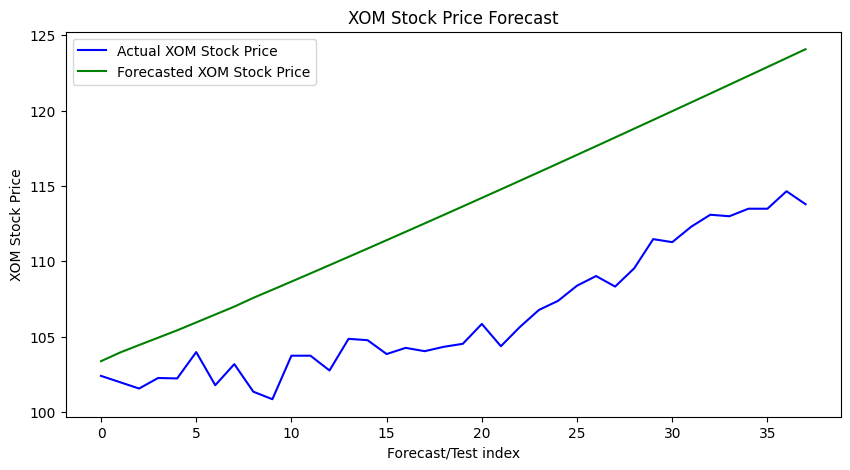

Forecast Performance for 1 day:
MAPE is  -0.95 %
Forecast Performance for 15 day:
MAPE is  4.19 %
R2 Score is  -14.57
Forecast Performance for 30 day:
MAPE is  6.25 %
R2 Score is  -6.3


In [155]:
forecast(model_6, xom_forecast, xom_test_min, xom_scaler_min, look_back, 'XOM')

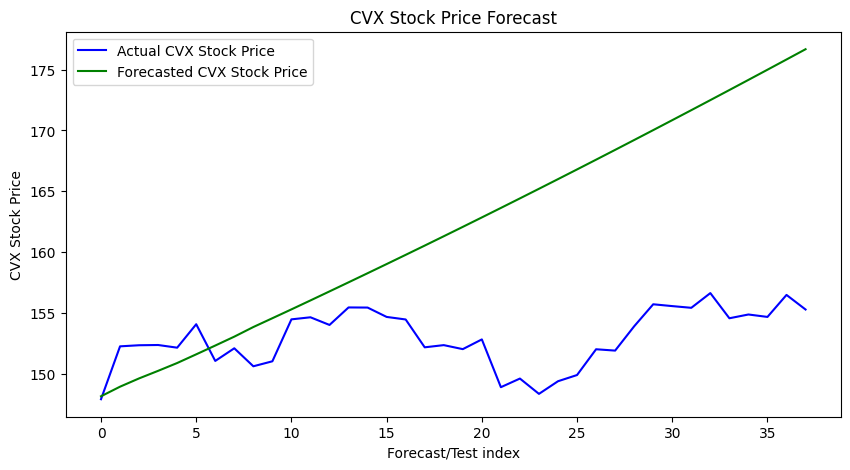

Forecast Performance for 1 day:
MAPE is  -0.16 %
Forecast Performance for 15 day:
MAPE is  1.35 %
R2 Score is  -0.32
Forecast Performance for 30 day:
MAPE is  4.83 %
R2 Score is  -19.06


In [156]:
forecast(model_6, cvx_forecast, cvx_test_min, cvx_scaler_min, look_back, 'CVX')